##Dataset Visualization

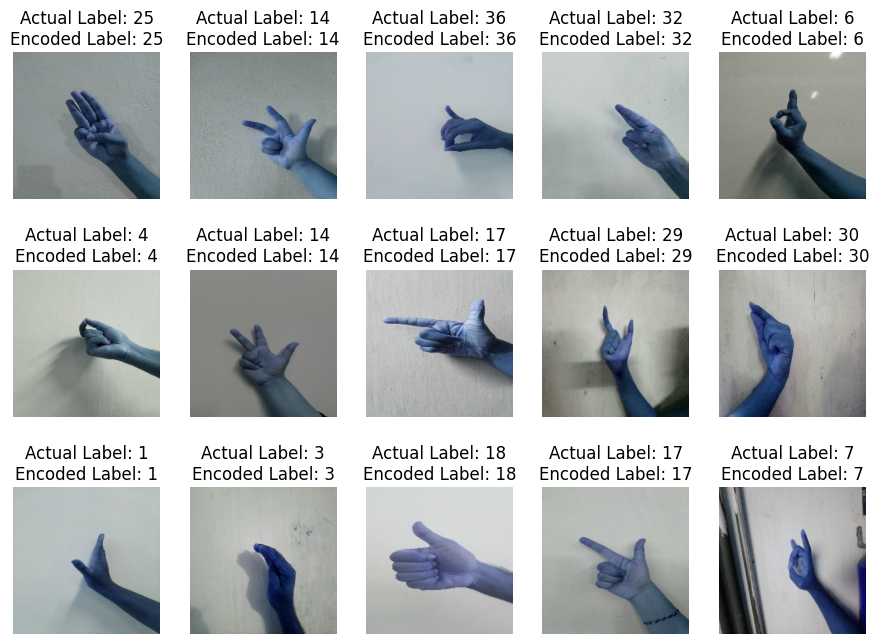

In [ ]:
import random
random_indices = random.sample(range(len(data)), 15)
plt.figure(figsize=(11,8))
j=1
for i in random_indices:
    plt.subplot(3,5,j); j+=1
    plt.imshow(data[i])
    plt.axis('off')
    plt.title('Actual Label: {}\nEncoded Label: {}'.format(label[i], labels[i]))



# ResNet50 Acc 92 Augmentation






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> ResNet50
*   Accuracy -> 92





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

100% 166M/166M [00:09<00:00, 24.4MB/s]
100% 166M/166M [00:09<00:00, 19.3MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:


main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


28: 100%|██████████| 873/873 [00:00<00:00, 932.33it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


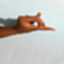

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

##Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
flatten_layer = Flatten()(resnet_model.output)
dense_layer1 = Dense(512, activation='relu', kernel_regularizer='l2')(flatten_layer)
dropout_layer = Dropout(0.2)(dense_layer1)
output_layer = Dense(38, activation='softmax')(dropout_layer)
model = Model(inputs=resnet_model.input, outputs=output_layer)

# Display the model summary
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BdSL/ResNet50/4-9-24/best_model_ResNet50_100epc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=100,
    callbacks=[checkpoint]

)

Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 4.2294 - accuracy: 0.3248
Epoch 1: val_loss improved from inf to 2.25261, saving model to /content/drive/MyDrive/BdSL/ResNet50/4-9-24/best_model_ResNet50_100epc.h5
415/415 [==============================] - 160s 196ms/step - loss: 4.2294 - accuracy: 0.3248 - val_loss: 2.2526 - val_accuracy: 0.4374
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 1.5543 - accuracy: 0.5820
Epoch 2: val_loss improved from 2.25261 to 2.02695, saving model to /content/drive/MyDrive/BdSL/ResNet50/4-9-24/best_model_ResNet50_100epc.h5
415/415 [==============================] - 58s 140ms/step - loss: 1.5543 - accuracy: 0.5820 - val_loss: 2.0269 - val_accuracy: 0.4684
Epoch 3/100
415/415 [==============================] - ETA: 0s - loss: 1.2007 - accuracy: 0.6806
Epoch 3: val_loss did not improve from 2.02695
415/415 [==============================] - 57s 136ms/step - loss: 1.2007 - accuracy: 0.6806 - val_loss: 2.4703 - 

##Accuracy Curve and Loss Curve

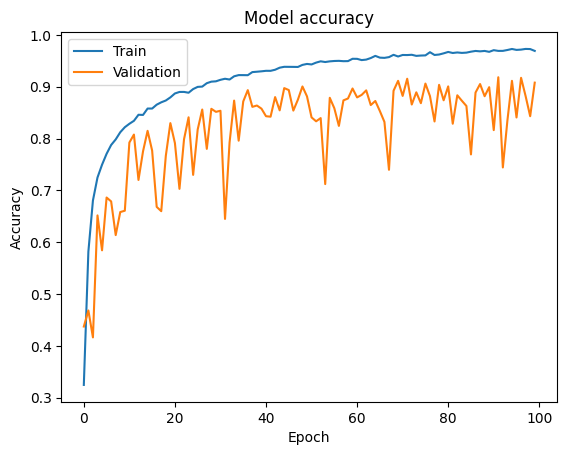

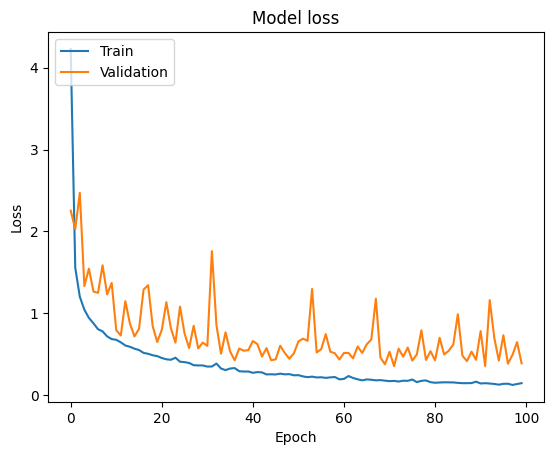

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Performance Measure

In [ ]:
import numpy as np
model.load_weights('/content/drive/MyDrive/BdSL/ResNet50/4-9-24/best_model_ResNet50_100epc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 3s 16ms/step
Accuracy: 0.9154738586710863
Precision: 0.9219253165976421
Recall: 0.9151877132827179
F1 Score: 0.9158461895214092


##Classification Report

In [ ]:


# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       168
           1       0.89      0.99      0.94       177
           2       0.95      0.98      0.97       192
           3       0.99      0.92      0.95       181
           4       0.95      0.92      0.93       187
           5       0.99      0.75      0.86       155
           6       0.96      0.88      0.91       176
           7       0.91      0.89      0.90       206
           8       0.85      0.97      0.90       161
           9       0.87      1.00      0.93       166
          10       0.80      0.94      0.87       177
          11       0.92      0.82      0.87       177
          12       0.97      0.90      0.93       172
          13       0.94      0.94      0.94       159
          14       0.99      0.90      0.94       163
          15       0.71      0.88      0.79       182
          16       0.91      0.75      0.82       187
          17       0.84    

## Confusion Matrix

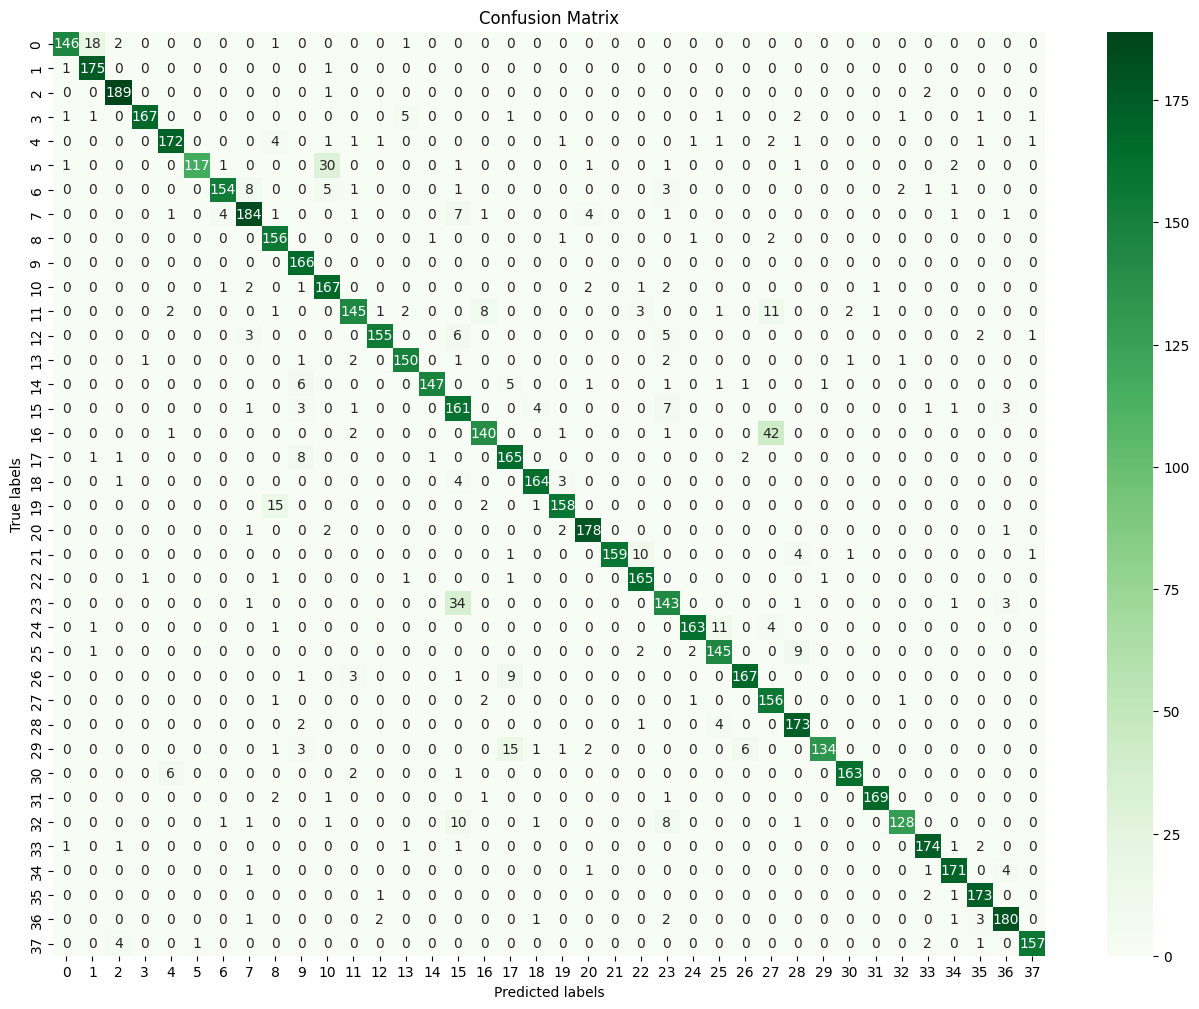

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Result analysis

1/1 [==============================] - 0s 23ms/step


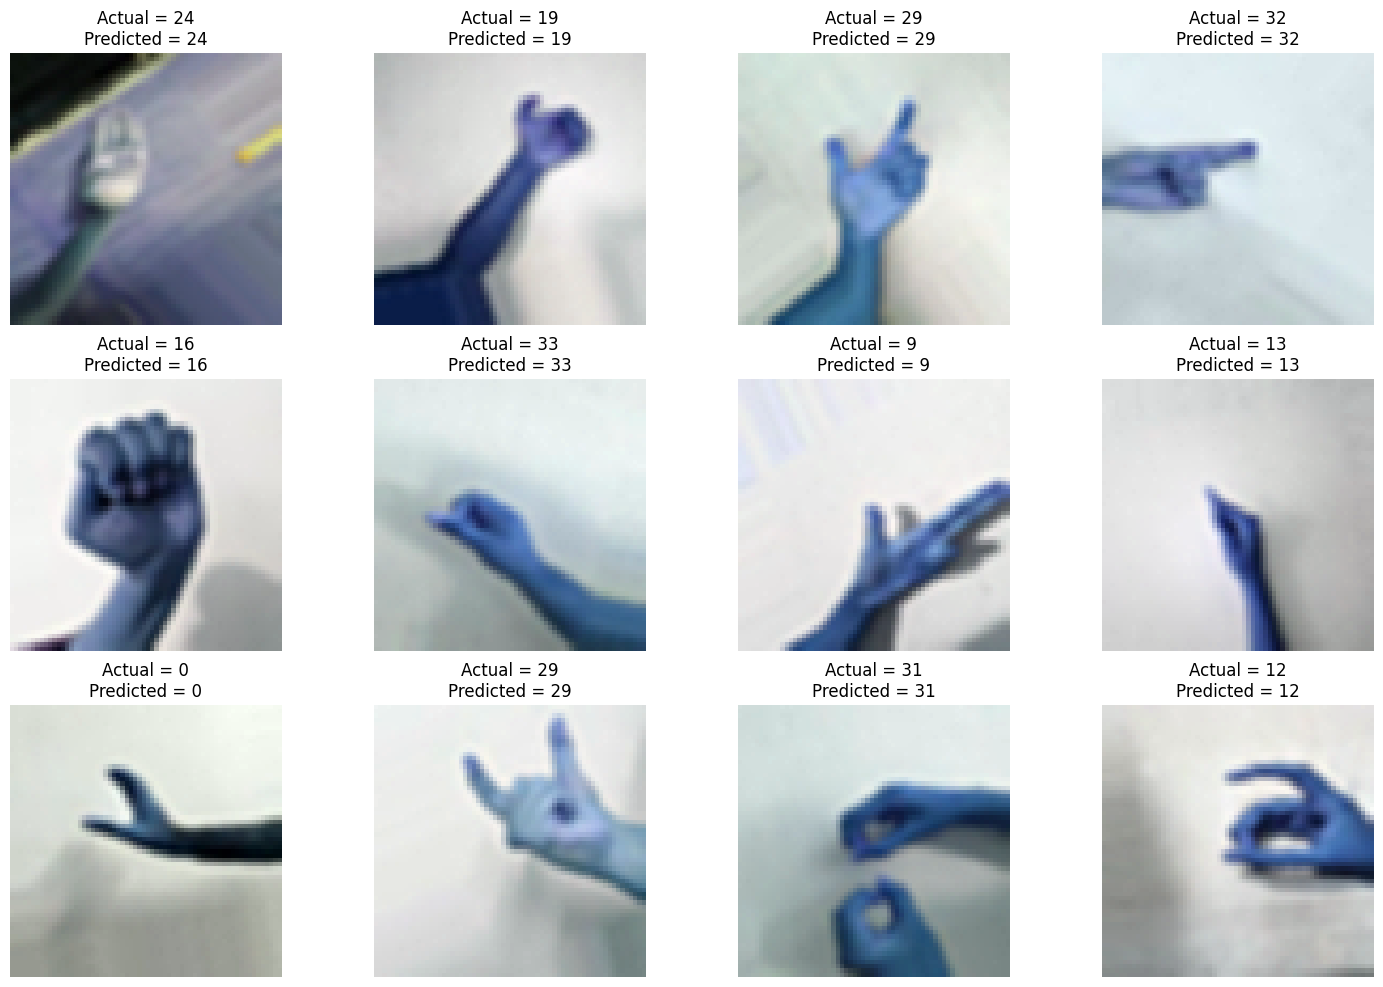

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()






# MobileNet Acc 94 Augmentation






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> MobileNet
*   Accuracy -> 94





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

 88% 146M/166M [00:01<00:00, 160MB/s]
100% 166M/166M [00:01<00:00, 93.3MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:


main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


14: 100%|██████████| 834/834 [00:00<00:00, 969.40it/s] 


In [ ]:
print(len(data))
print(len(labels))

33182
33182


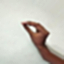

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

##Model

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNet with pretrained weights
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Flatten layer
flatten_layer = Flatten()(mobilenet_model.output)

# Dense layer with 512 units and ReLU activation
dense_layer1 = Dense(512, activation='relu', kernel_regularizer='l2')(flatten_layer)

# Dropout layer with rate 0.2
dropout_layer = Dropout(0.2)(dense_layer1)

# Output layer with 38 units and softmax activation (assuming you have 38 classes)
output_layer = Dense(38, activation='softmax')(dropout_layer)

# Create the model
model = Model(inputs=mobilenet_model.input, outputs=output_layer)

# Display the model summary
model.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 32, 32, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 32, 32, 32)        288       
 )                                                               
                                                              

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BdSL/mblent/4-9-24/best_model_mobileNet_100epc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=100,
    callbacks=[checkpoint]

)

Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 4.8741 - accuracy: 0.3768
Epoch 1: val_loss improved from inf to 2.10258, saving model to /content/drive/MyDrive/BdSL/mblent/4-9-24/best_model_mobileNet_100epc.h5
415/415 [==============================] - 103s 159ms/step - loss: 4.8741 - accuracy: 0.3768 - val_loss: 2.1026 - val_accuracy: 0.5507
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 1.5426 - accuracy: 0.6358
Epoch 2: val_loss improved from 2.10258 to 1.51059, saving model to /content/drive/MyDrive/BdSL/mblent/4-9-24/best_model_mobileNet_100epc.h5
415/415 [==============================] - 43s 103ms/step - loss: 1.5426 - accuracy: 0.6358 - val_loss: 1.5106 - val_accuracy: 0.6128
Epoch 3/100
415/415 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.7089
Epoch 3: val_loss improved from 1.51059 to 1.09562, saving model to /content/drive/MyDrive/BdSL/mblent/4-9-24/best_model_mobileNet_100epc.h5
415/415 [============

##Accuracy Curve and Loss Curve

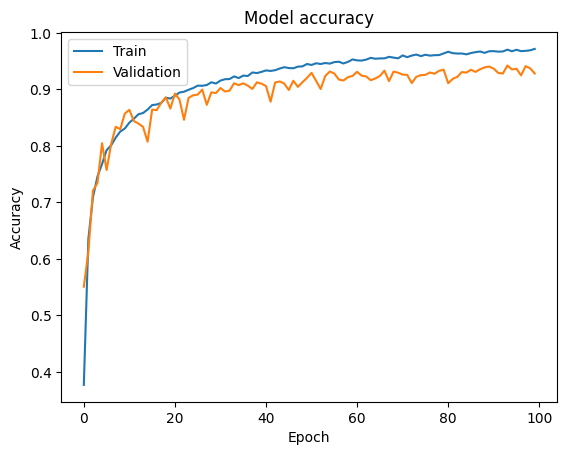

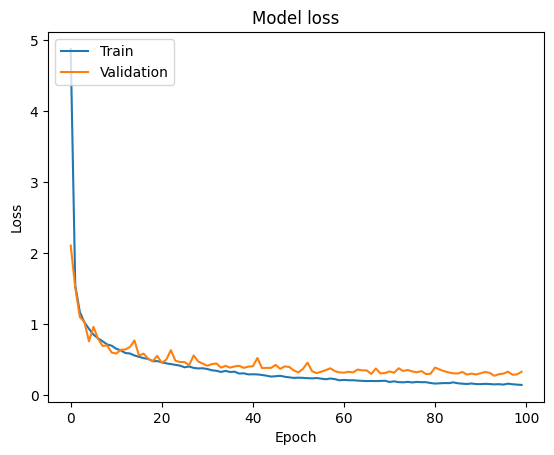

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Performance Measure

In [ ]:
model.load_weights('/content/drive/MyDrive/BdSL/mblent/4-9-24/best_model_mobileNet_100epc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 1s 5ms/step
Accuracy: 0.9422932047611873
Precision: 0.943625410716567
Recall: 0.9422425109450646
F1 Score: 0.9424156579149972


##Classification Report

In [ ]:


# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       168
           1       0.95      0.95      0.95       177
           2       0.98      0.97      0.98       192
           3       0.96      0.97      0.96       181
           4       0.94      0.95      0.94       187
           5       0.91      0.95      0.93       155
           6       0.91      0.93      0.92       176
           7       0.91      0.93      0.92       206
           8       0.94      0.96      0.95       161
           9       0.95      0.99      0.97       166
          10       0.93      0.88      0.90       177
          11       0.92      0.90      0.91       177
          12       0.98      0.98      0.98       172
          13       0.97      0.90      0.93       159
          14       0.97      0.95      0.96       163
          15       0.86      0.87      0.87       182
          16       0.87      0.95      0.91       187
          17       0.98    

##Confusion Matrix

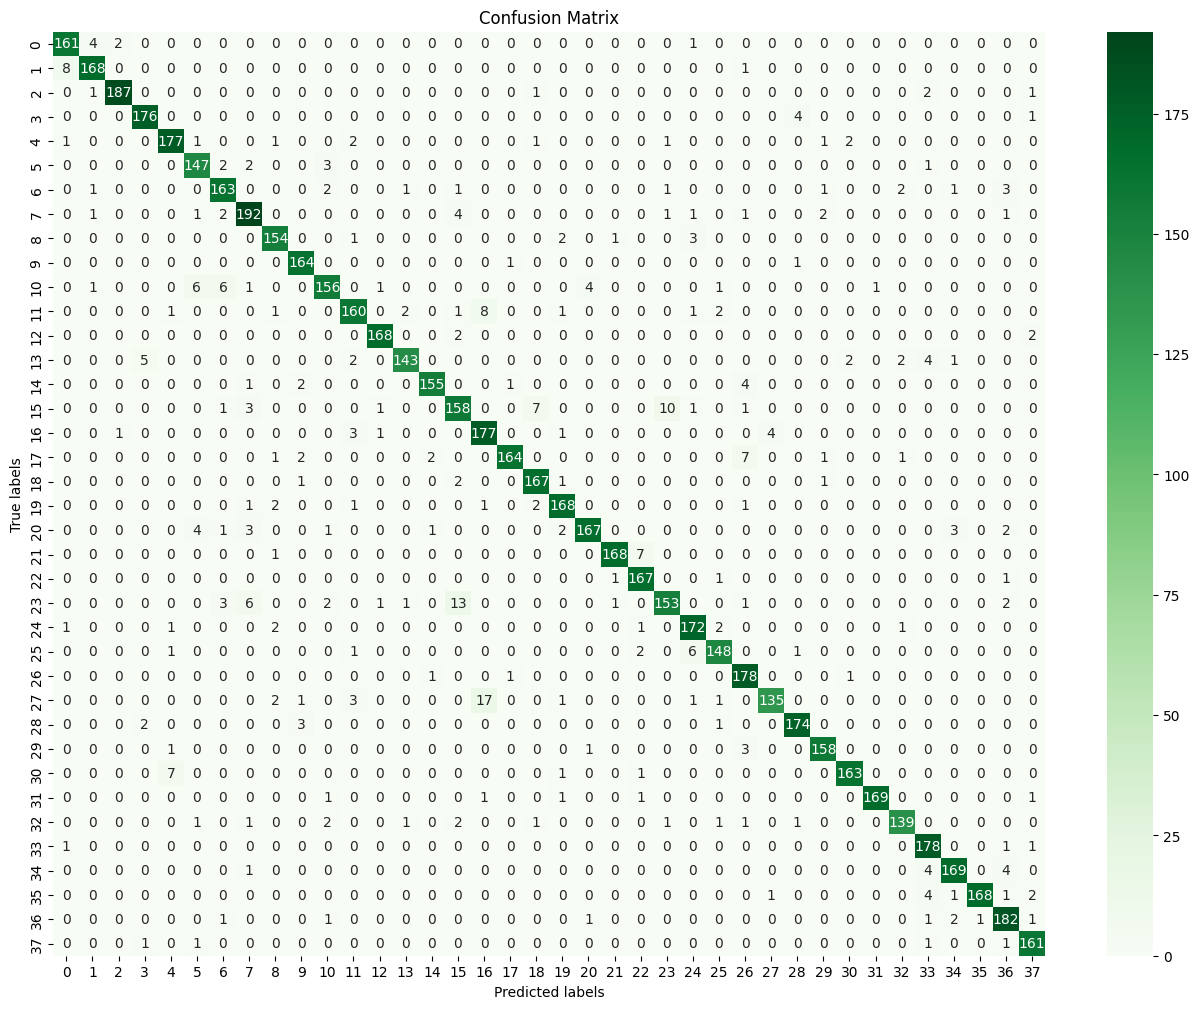

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##Result Analysis

1/1 [==============================] - 0s 20ms/step


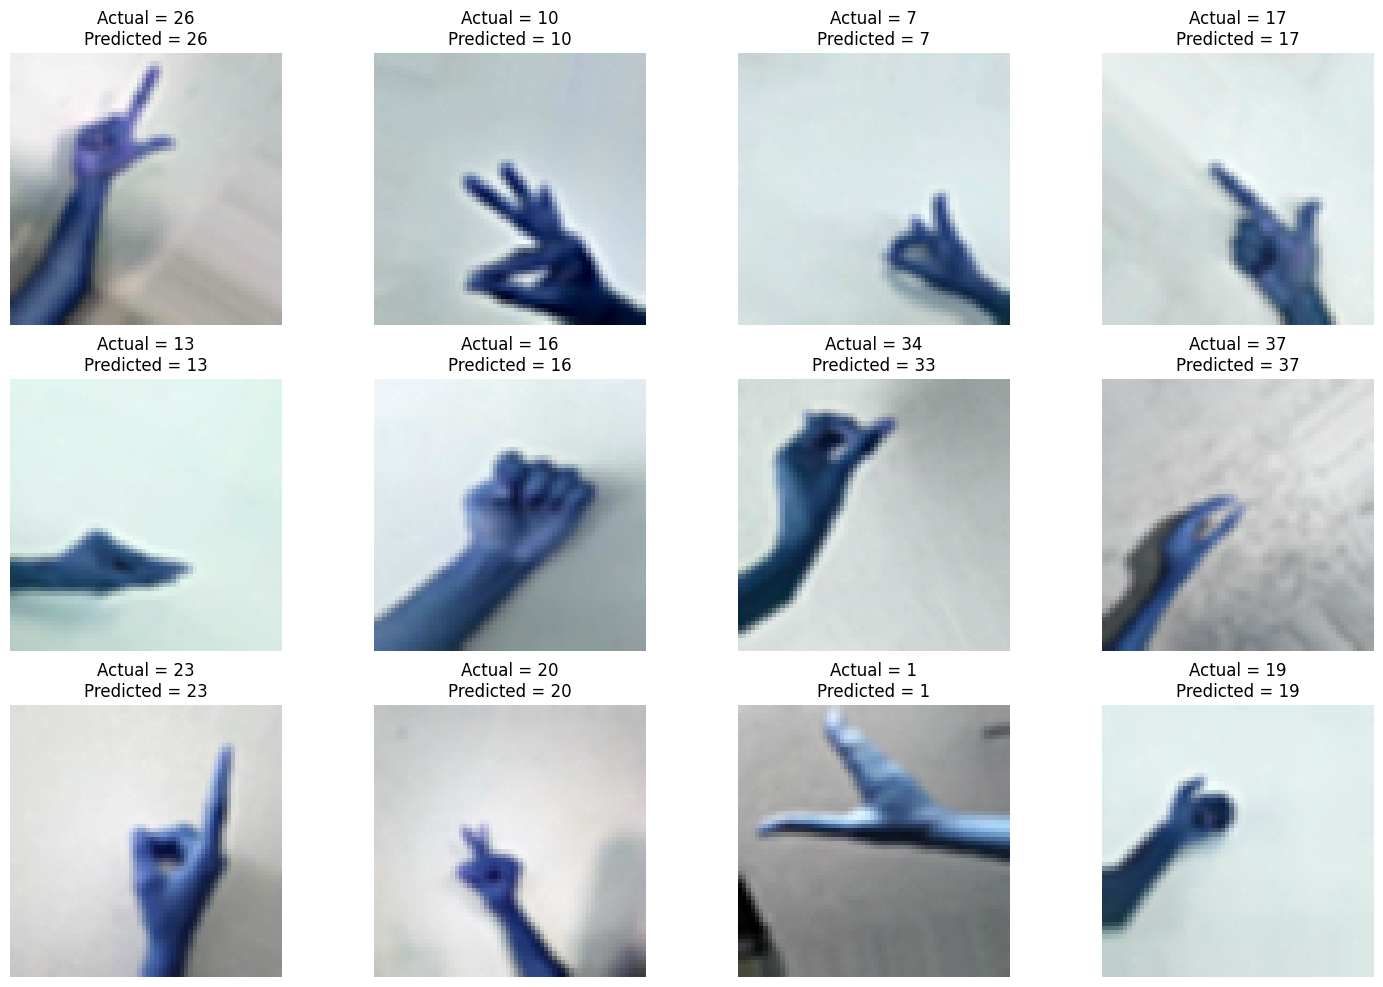

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


# InceptionV3 Acc 84 Augmentation






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> InceptionV3
*   Accuracy -> 84





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

100% 4.07G/4.07G [00:26<00:00, 253MB/s]
100% 4.07G/4.07G [00:26<00:00, 167MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 81, 81)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
main_folder_path = "/content/AUGMENTED_DATASET-20240326T154347Z-001/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


21: 100%|██████████| 879/879 [00:01<00:00, 730.91it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


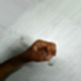

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pretrained on ImageNet
model = InceptionV3(weights='imagenet', input_shape=(75, 75, 3), include_top=False)

# Display model summary
model.summary()

# Flatten the output of the last convolutional layer
flat1 = Flatten()(model.layers[-1].output)

# Add Dense layers for classification
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)

# Output layer with softmax activation for 38 classes
output = Dense(38, activation='softmax')(class4)

# Define new model
model = Model(inputs=model.inputs, outputs=output)

# Display model summary
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 37, 37, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 37, 37, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalizati

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BdSL/inception/best_model_inception_100epc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=100,
    callbacks=[checkpoint]

)

Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 3.6424 - accuracy: 0.0247
Epoch 1: val_loss improved from inf to 3.63694, saving model to /content/drive/MyDrive/BdSL/inception/best_model_inception_100epc.h5
415/415 [==============================] - 120s 183ms/step - loss: 3.6424 - accuracy: 0.0247 - val_loss: 3.6369 - val_accuracy: 0.0234
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 3.4725 - accuracy: 0.0458
Epoch 2: val_loss did not improve from 3.63694
415/415 [==============================] - 72s 172ms/step - loss: 3.4725 - accuracy: 0.0458 - val_loss: 4.3069 - val_accuracy: 0.0325
Epoch 3/100
415/415 [==============================] - ETA: 0s - loss: 3.2211 - accuracy: 0.0713
Epoch 3: val_loss did not improve from 3.63694
415/415 [==============================] - 67s 161ms/step - loss: 3.2211 - accuracy: 0.0713 - val_loss: 90.2057 - val_accuracy: 0.0434
Epoch 4/100
415/415 [==============================] - ETA: 0s - loss: 3.0275 

##Accuracy Curve and Loss Curve

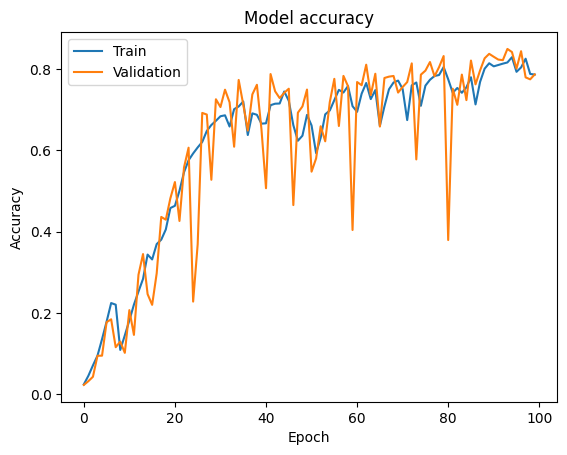

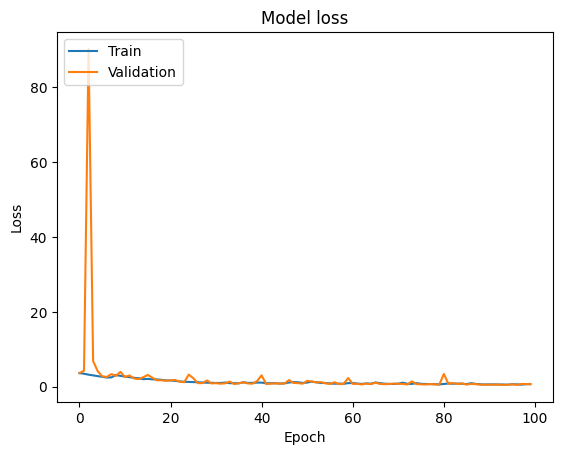

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Performance Measure

In [ ]:
model.load_weights('/content/drive/MyDrive/BdSL/inception/best_model_inception_100epc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 4s 15ms/step
Accuracy: 0.849028175380443
Precision: 0.855315423609394
Recall: 0.8479081467268649
F1 Score: 0.8493965686538163


##Classification Report

In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       184
           1       0.86      0.92      0.89       157
           2       0.95      0.89      0.92       184
           3       0.89      0.86      0.88       157
           4       0.88      0.89      0.88       169
           5       0.88      0.83      0.85       179
           6       0.82      0.80      0.81       168
           7       0.91      0.78      0.84       162
           8       0.89      0.85      0.87       169
           9       0.93      0.93      0.93       179
          10       0.80      0.75      0.78       168
          11       0.83      0.75      0.79       175
          12       0.97      0.93      0.95       182
          13       0.74      0.81      0.77       176
          14       0.93      0.90      0.91       177
          15       0.76      0.86      0.81       184
          16       0.60      0.74      0.66       165
          17       0.81    

##Confusion Matrix

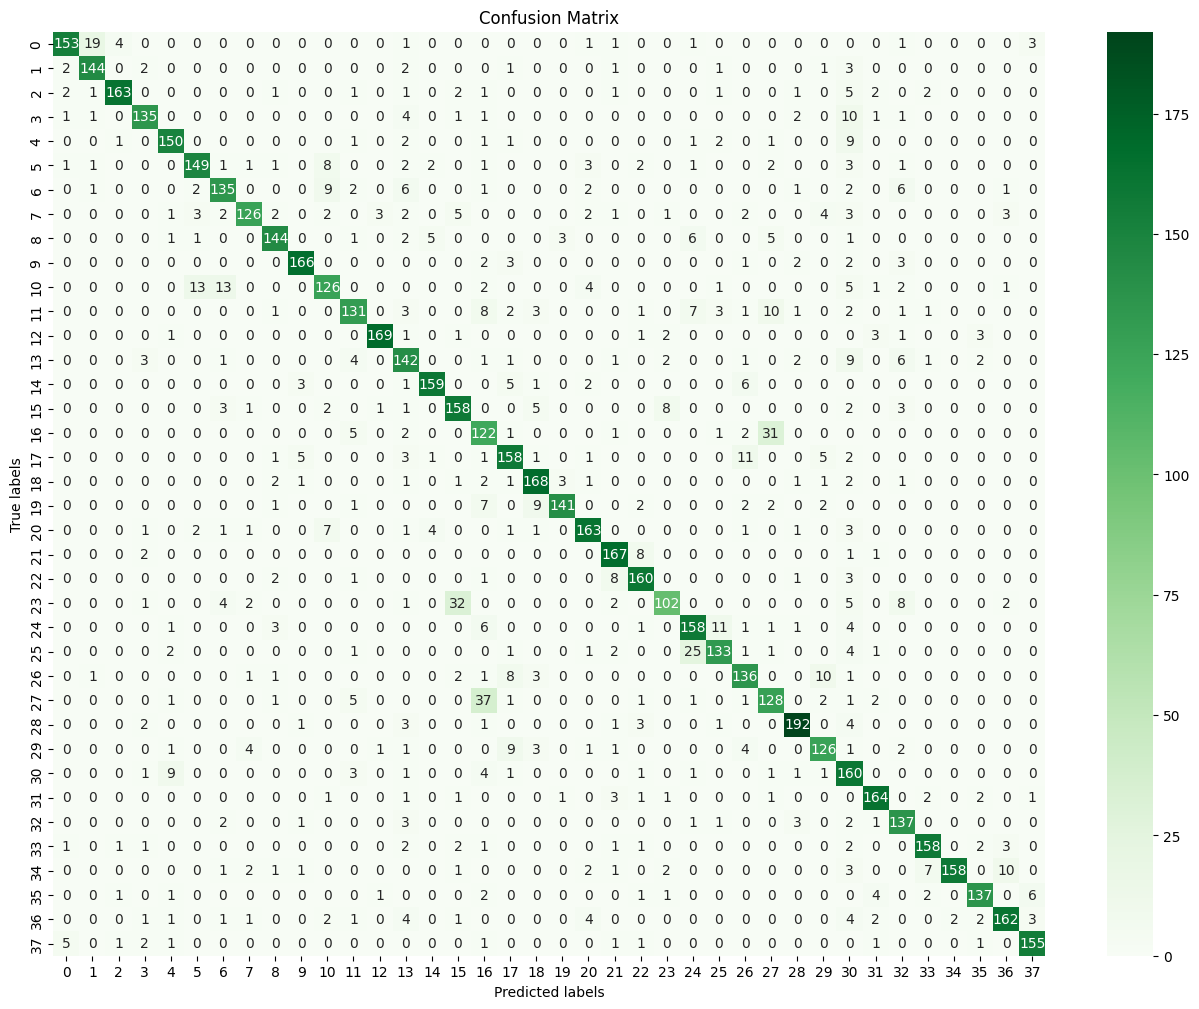

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##Result Analysis

1/1 [==============================] - 0s 23ms/step


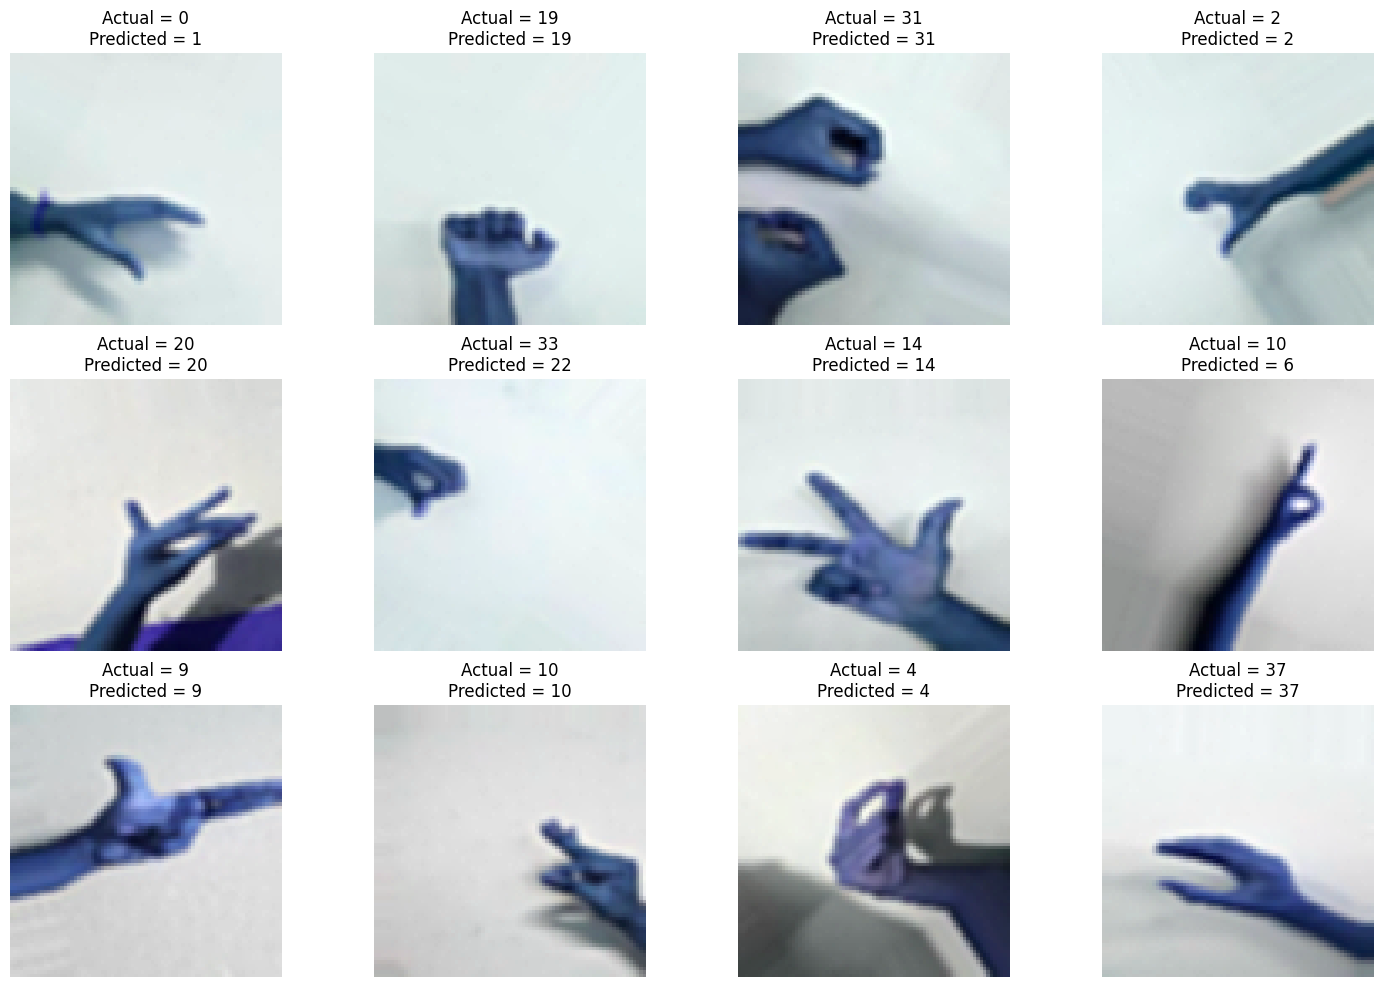

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/BdSL/inception/best_model_inception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Yolov5 Acc 94 Augmentation






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> YOLOv5
*   Accuracy -> 94





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

100% 166M/166M [00:09<00:00, 24.4MB/s]
100% 166M/166M [00:09<00:00, 19.3MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:


main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


14: 100%|██████████| 834/834 [00:00<00:00, 1025.27it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


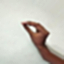

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint

def conv_bn_leaky(inputs, filters, kernel_size, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def CSPDarknet53(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Stem
    x = conv_bn_leaky(inputs, 32, 3, strides=1)
    x = conv_bn_leaky(x, 64, 3, strides=2)

    # CSP Blocks
    for _ in range(2):
        x_shortcut = x
        x = conv_bn_leaky(x, 64, 1)
        x = conv_bn_leaky(x, 64, 3)
        x = layers.Concatenate()([x, x_shortcut])

    x = conv_bn_leaky(x, 128, 3, strides=2)

    for _ in range(2):
        x_shortcut = x
        x = conv_bn_leaky(x, 64, 1)
        x = conv_bn_leaky(x, 64, 3)
        x = layers.Concatenate()([x, x_shortcut])

    x = conv_bn_leaky(x, 256, 3, strides=2)

    for _ in range(2):
        x_shortcut = x
        x = conv_bn_leaky(x, 128, 1)
        x = conv_bn_leaky(x, 128, 3)
        x = layers.Concatenate()([x, x_shortcut])

    return Model(inputs, x)

def YOLOv5(input_shape, num_classes):
    backbone = CSPDarknet53(input_shape)

    x = conv_bn_leaky(backbone.output, 512, 3, strides=2)
    x = conv_bn_leaky(x, 256, 1)
    x = conv_bn_leaky(x, 512, 3)
    x = conv_bn_leaky(x, 256, 1)
    x = conv_bn_leaky(x, 512, 3)
    x = layers.Conv2D(num_classes, 1, padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Activation('softmax')(x)

    model = Model(backbone.input, x)
    return model

# Define input shape and number of classes
input_shape = (64, 64, 3)
num_classes = 38

# Create YOLOv5 model
model = YOLOv5(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Yolov5_client/best_model_yolov5.h5',monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# Print model summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 64, 64, 32)           896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 64, 64, 32)           128       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_21 (LeakyReLU)  (None, 64, 64, 32)           0         ['batch_normalization_21

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BdSL/Yolov5/9-4-24/best_model_yolo_100epc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=100,
    callbacks=[checkpoint]

)

Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 2.5403 - accuracy: 0.2647
Epoch 1: val_loss improved from inf to 4.77406, saving model to /content/drive/MyDrive/BdSL/Yolov5/9-4-24/best_model_yolo_100epc.h5
415/415 [==============================] - 77s 136ms/step - loss: 2.5403 - accuracy: 0.2647 - val_loss: 4.7741 - val_accuracy: 0.2162
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 1.3680 - accuracy: 0.5688
Epoch 2: val_loss improved from 4.77406 to 1.91844, saving model to /content/drive/MyDrive/BdSL/Yolov5/9-4-24/best_model_yolo_100epc.h5
415/415 [==============================] - 53s 127ms/step - loss: 1.3680 - accuracy: 0.5688 - val_loss: 1.9184 - val_accuracy: 0.4748
Epoch 3/100
415/415 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.6561
Epoch 3: val_loss improved from 1.91844 to 1.28610, saving model to /content/drive/MyDrive/BdSL/Yolov5/9-4-24/best_model_yolo_100epc.h5
415/415 [============================

##Accuracy Curve and Loss Curve

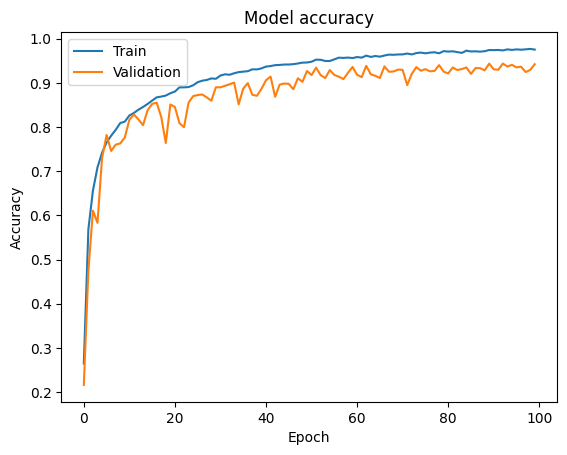

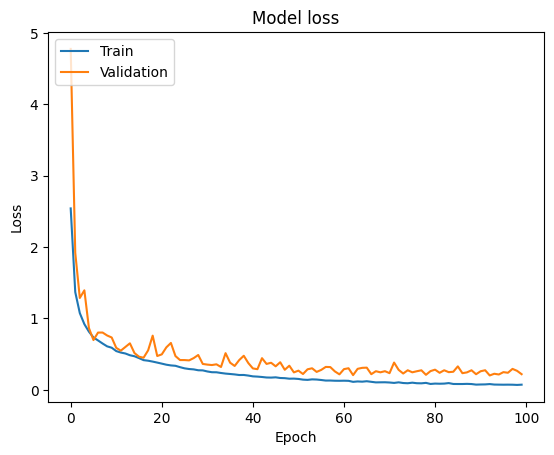

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Performance Measure

In [ ]:
model.load_weights('/content/drive/MyDrive/BdSL/Yolov5/9-4-24/best_model_yolo_100epc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 3s 11ms/step
Accuracy: 0.9437999095977098
Precision: 0.9444609572535365
Recall: 0.9435406453004991
F1 Score: 0.9436308380571956


##Classification Report

In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       168
           1       0.94      0.96      0.95       177
           2       0.99      0.99      0.99       192
           3       0.96      0.93      0.95       181
           4       0.95      0.94      0.94       187
           5       0.94      0.94      0.94       155
           6       0.96      0.97      0.96       176
           7       0.97      0.93      0.95       206
           8       0.96      0.94      0.95       161
           9       0.94      0.96      0.95       166
          10       0.92      0.92      0.92       177
          11       0.95      0.93      0.94       177
          12       0.98      0.95      0.96       172
          13       0.96      0.96      0.96       159
          14       0.96      0.96      0.96       163
          15       0.85      0.87      0.86       182
          16       0.89      0.94      0.91       187
          17       0.93    

## Confusion Matrix

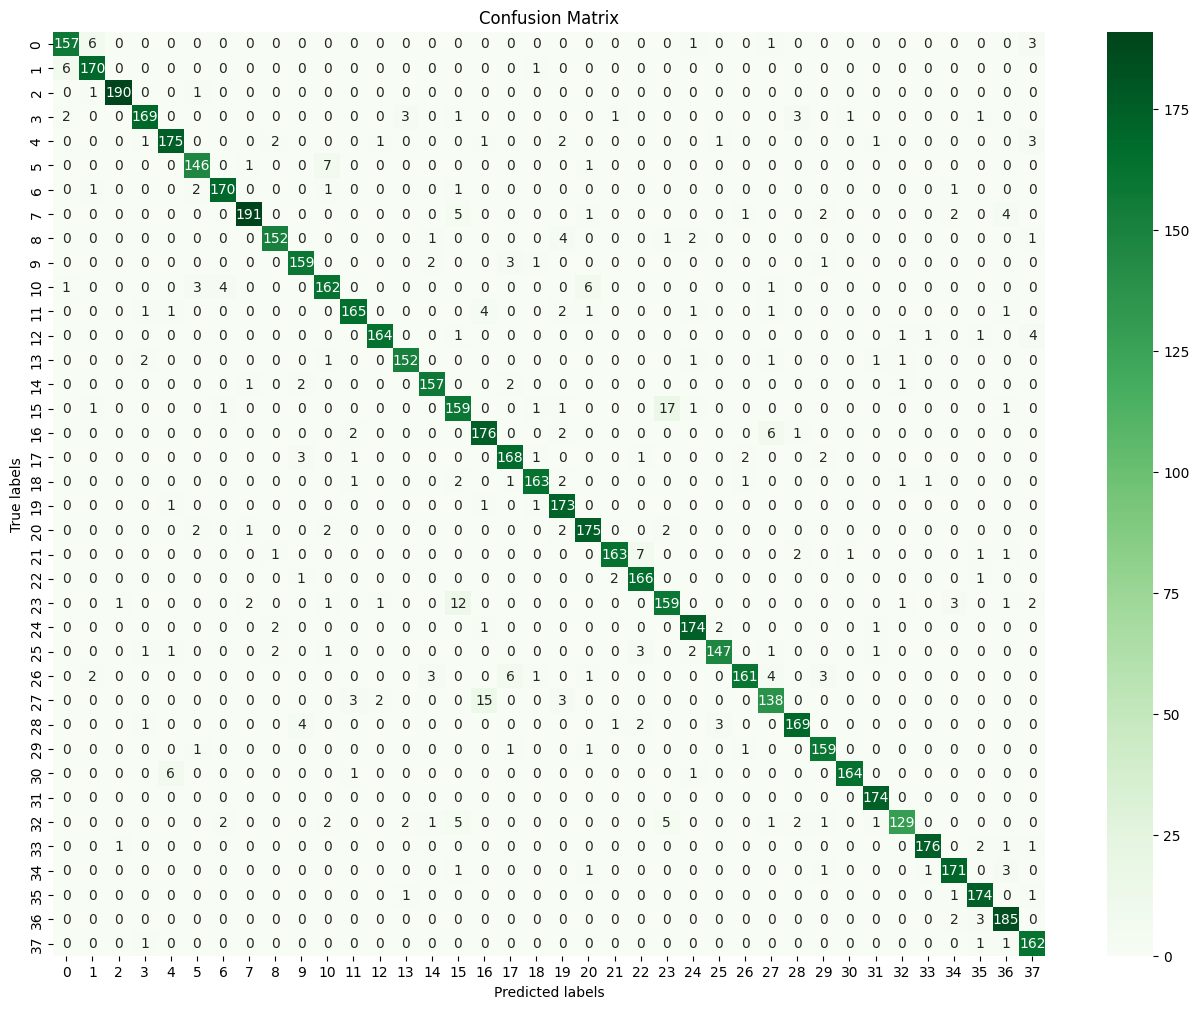

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##Result Analysis

1/1 [==============================] - 0s 19ms/step


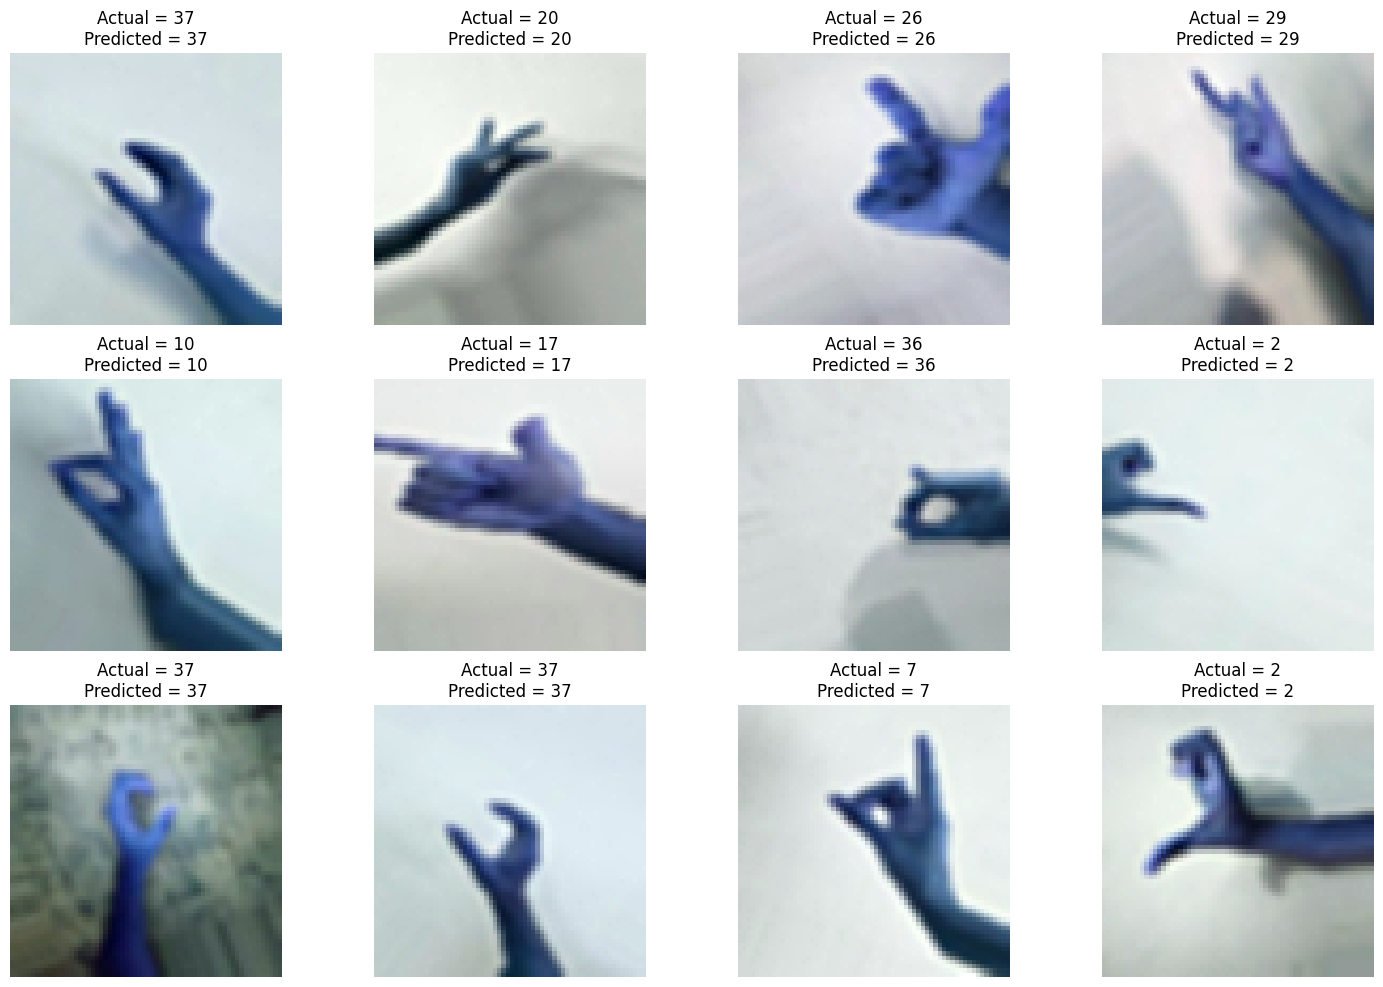

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/BdSL/Yolov5/9-4-24/yolo_94acc_100epc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# EfficientNetB1 Acc 95 Augmentation






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> EfficientNetB1 (No regularizer and Learning Rate)
*   Accuracy -> 95





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

 99% 165M/166M [00:06<00:00, 29.3MB/s]
100% 166M/166M [00:06<00:00, 27.3MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


14: 100%|██████████| 834/834 [00:00<00:00, 1053.41it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


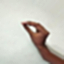

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB1

# Load the EfficientNetB1 model pretrained on ImageNet
model = EfficientNetB1(weights='imagenet', input_shape=(64, 64, 3), include_top=False)

# Display model summary
model.summary()

# Flatten the output of the last convolutional layer
flat1 = Flatten()(model.layers[-1].output)

# Add Dense layers for classification
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)

# Output layer with softmax activation for 38 classes
output = Dense(38, activation='softmax')(class4)

# Define new model
model = Model(inputs=model.inputs, outputs=output)

# Display model summary
model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 64, 64, 3)            0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 64, 64, 3)            7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 64, 64, 3)            0         ['normalization_1

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BdSL/EfficientNetb1/4-11-24/best_model_efficientNet_100epc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=100,
    callbacks=[checkpoint]

)

Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 1.9681 - accuracy: 0.4322
Epoch 1: val_loss improved from inf to 1.21219, saving model to /content/drive/MyDrive/BdSL/EfficientNetb1/4-11-24/best_model_efficientNet_100epc.h5
415/415 [==============================] - 128s 165ms/step - loss: 1.9681 - accuracy: 0.4322 - val_loss: 1.2122 - val_accuracy: 0.6357
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 1.0159 - accuracy: 0.7007
Epoch 2: val_loss improved from 1.21219 to 0.92211, saving model to /content/drive/MyDrive/BdSL/EfficientNetb1/4-11-24/best_model_efficientNet_100epc.h5
415/415 [==============================] - 65s 156ms/step - loss: 1.0159 - accuracy: 0.7007 - val_loss: 0.9221 - val_accuracy: 0.7506
Epoch 3/100
415/415 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.7657
Epoch 3: val_loss improved from 0.92211 to 0.81590, saving model to /content/drive/MyDrive/BdSL/EfficientNetb1/4-11-24/best_model_efficien

##Accuracy Curve and Loss Curve

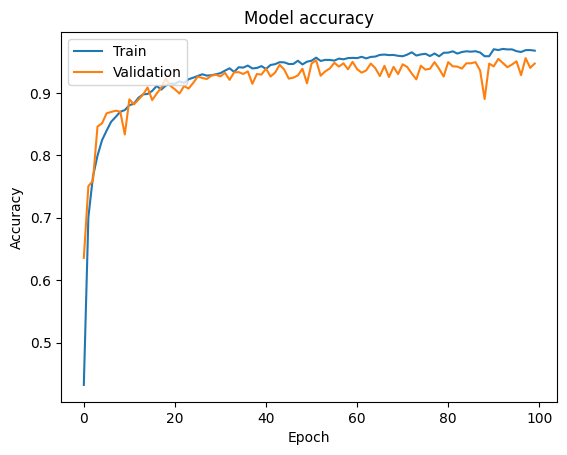

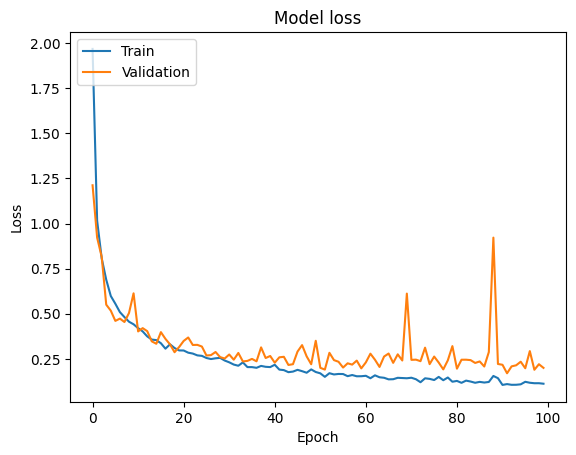

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Performance Measure

In [ ]:
model.load_weights('/content/drive/MyDrive/BdSL/EfficientNetb1/4-11-24/best_model_efficientNet_100epc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 6s 19ms/step
Accuracy: 0.9543468434533675
Precision: 0.9549698380847005
Recall: 0.9548421933338473
F1 Score: 0.9545103994639026


##Classification Report

In [ ]:

# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       168
           1       0.93      0.98      0.95       177
           2       0.99      0.96      0.98       192
           3       0.98      0.98      0.98       181
           4       0.97      0.93      0.95       187
           5       0.90      0.96      0.93       155
           6       0.92      0.96      0.94       176
           7       0.97      0.92      0.95       206
           8       0.92      0.97      0.94       161
           9       0.97      0.99      0.98       166
          10       0.95      0.89      0.92       177
          11       0.97      0.95      0.96       177
          12       0.99      0.99      0.99       172
          13       0.99      0.97      0.98       159
          14       0.96      0.96      0.96       163
          15       0.87      0.90      0.89       182
          16       0.90      0.91      0.91       187
          17       0.99    

##Confusion Matrix

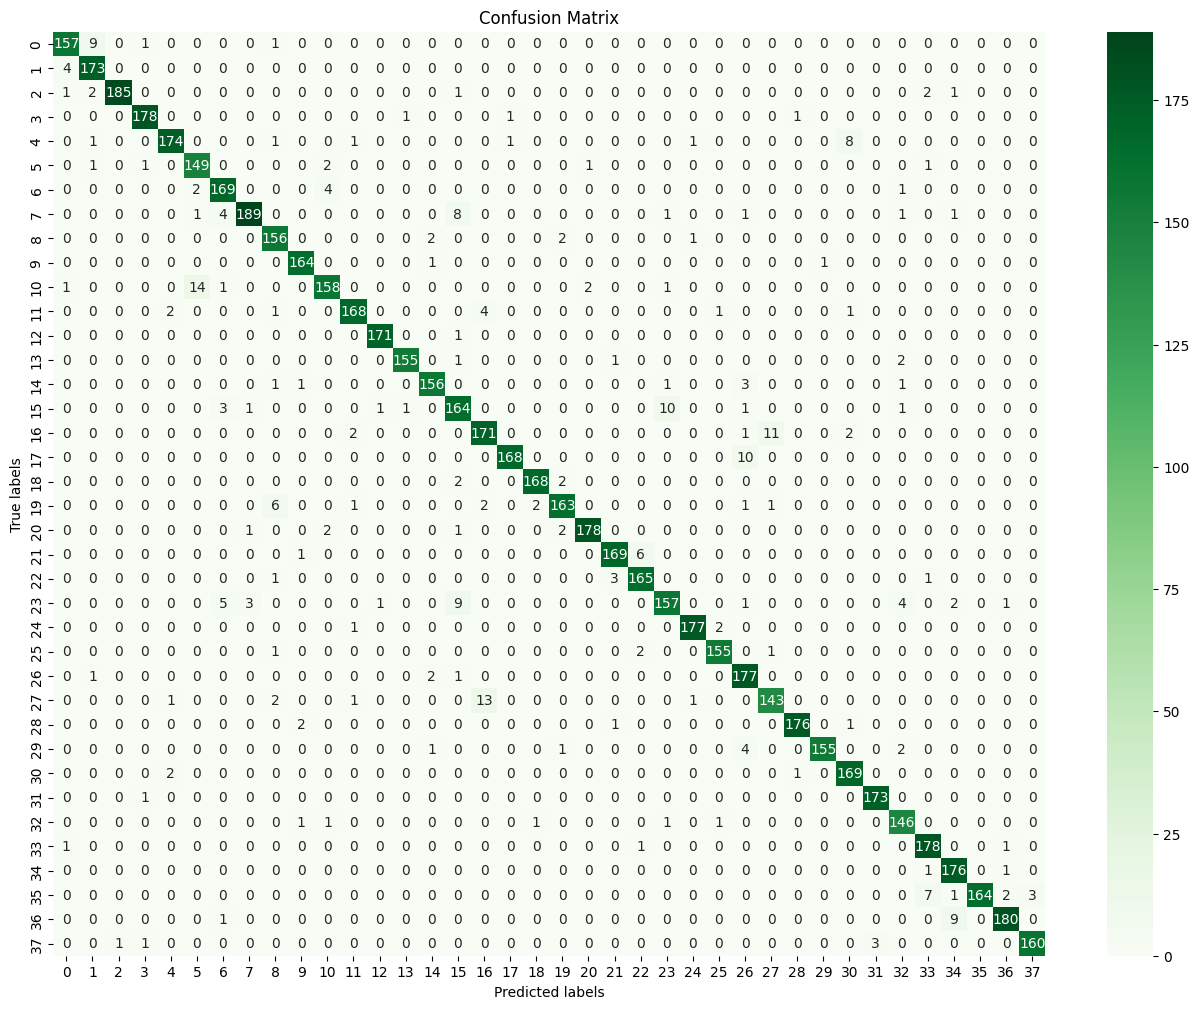

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##Result Analysis

1/1 [==============================] - 0s 40ms/step


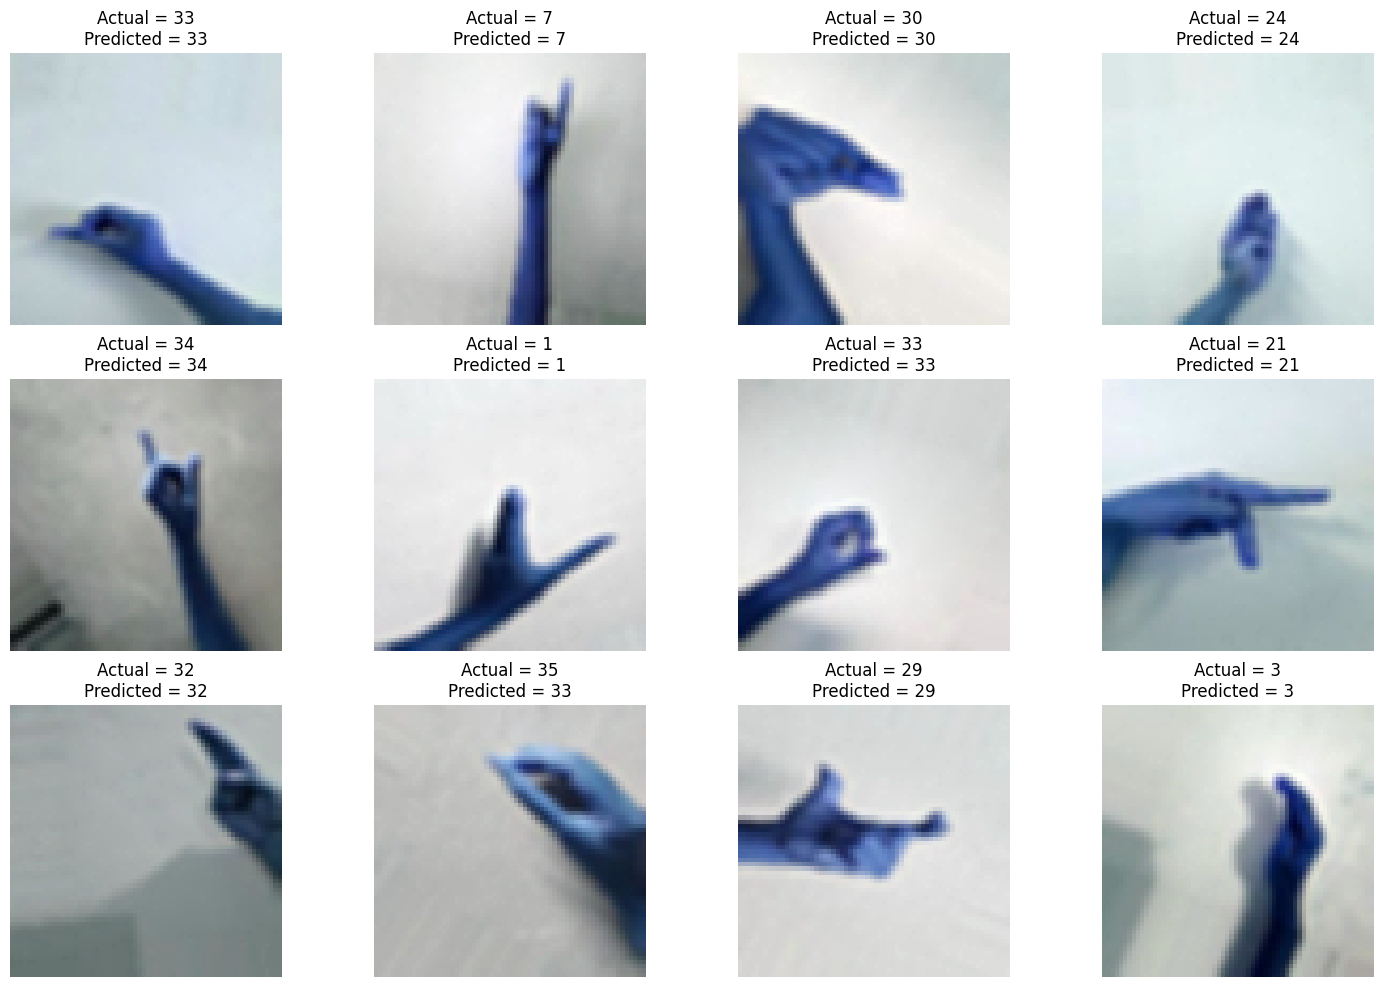

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_50epcs_95_acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# DenseNet121 Acc 92 Augmentation







*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> DenseNet121 (No regularizer and Learning Rate)
*   Accuracy -> 92





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

 97% 161M/166M [00:03<00:00, 50.2MB/s]
100% 166M/166M [00:03<00:00, 54.1MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


0: 100%|██████████| 882/882 [00:00<00:00, 952.77it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


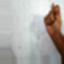

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Display model summary
base_model.summary()

# Flatten the output of the last convolutional layer
flatten_layer = Flatten()(base_model.output)

# Add Dense layers for classification
dense_layer_1 = Dense(1024, activation='relu')(flatten_layer)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(128, activation='relu')(dense_layer_3)

# Output layer with softmax activation for 38 classes
output_layer = Dense(38, activation='softmax')(dense_layer_4)

# Define new model
model = Model(inputs=base_model.inputs, outputs=output_layer)

# Display model summary
model.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 32, 32, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BSDL/DenseNet/best_model_densenet_100epc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=100,
    callbacks=[checkpoint]
)

Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 2.1794 - accuracy: 0.3480
Epoch 1: val_loss improved from inf to 2.19072, saving model to /content/drive/MyDrive/BSDL/DenseNet/best_model_densenet_100epc.h5
415/415 [==============================] - 144s 178ms/step - loss: 2.1794 - accuracy: 0.3480 - val_loss: 2.1907 - val_accuracy: 0.4262
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 1.1832 - accuracy: 0.6362
Epoch 2: val_loss improved from 2.19072 to 1.38026, saving model to /content/drive/MyDrive/BSDL/DenseNet/best_model_densenet_100epc.h5
415/415 [==============================] - 64s 154ms/step - loss: 1.1832 - accuracy: 0.6362 - val_loss: 1.3803 - val_accuracy: 0.6266
Epoch 3/100
415/415 [==============================] - ETA: 0s - loss: 0.9008 - accuracy: 0.7256
Epoch 3: val_loss improved from 1.38026 to 1.05133, saving model to /content/drive/MyDrive/BSDL/DenseNet/best_model_densenet_100epc.h5
415/415 [==============================

##Accuracy Curve and Loss Curve

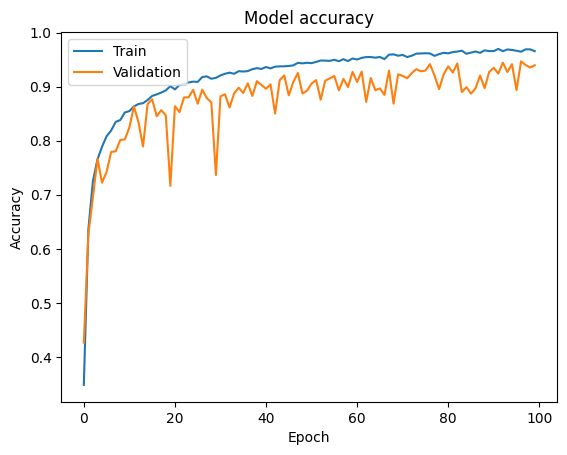

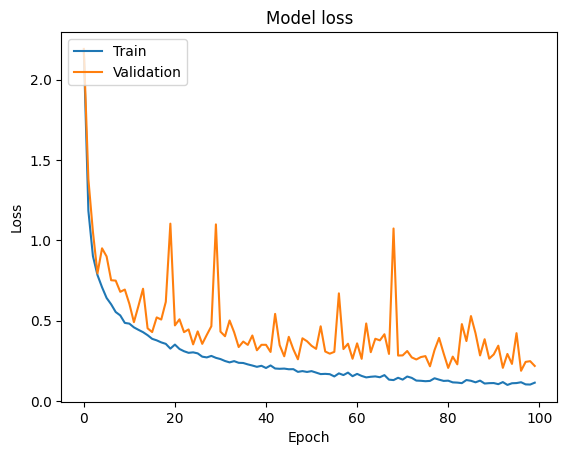

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Performance Measure

In [ ]:
model.load_weights('/content/drive/MyDrive/BSDL/DenseNet/best_model_densenet_100epc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 5s 14ms/step
Accuracy: 0.9471146602380593
Precision: 0.9480944573342971
Recall: 0.9473774352755593
F1 Score: 0.9472346505223681


##Classification Report

In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       168
           1       0.98      0.97      0.97       177
           2       0.98      0.99      0.98       192
           3       1.00      0.90      0.95       181
           4       0.94      0.94      0.94       187
           5       0.94      0.93      0.94       155
           6       0.94      0.91      0.92       176
           7       0.97      0.95      0.96       206
           8       0.99      0.96      0.97       161
           9       0.99      0.98      0.98       166
          10       0.87      0.90      0.88       177
          11       0.91      0.95      0.93       177
          12       0.97      0.97      0.97       172
          13       0.91      0.99      0.95       159
          14       0.96      0.95      0.96       163
          15       0.84      0.87      0.85       182
          16       0.95      0.86      0.90       187
          17       0.96    

##Confusion Matrix

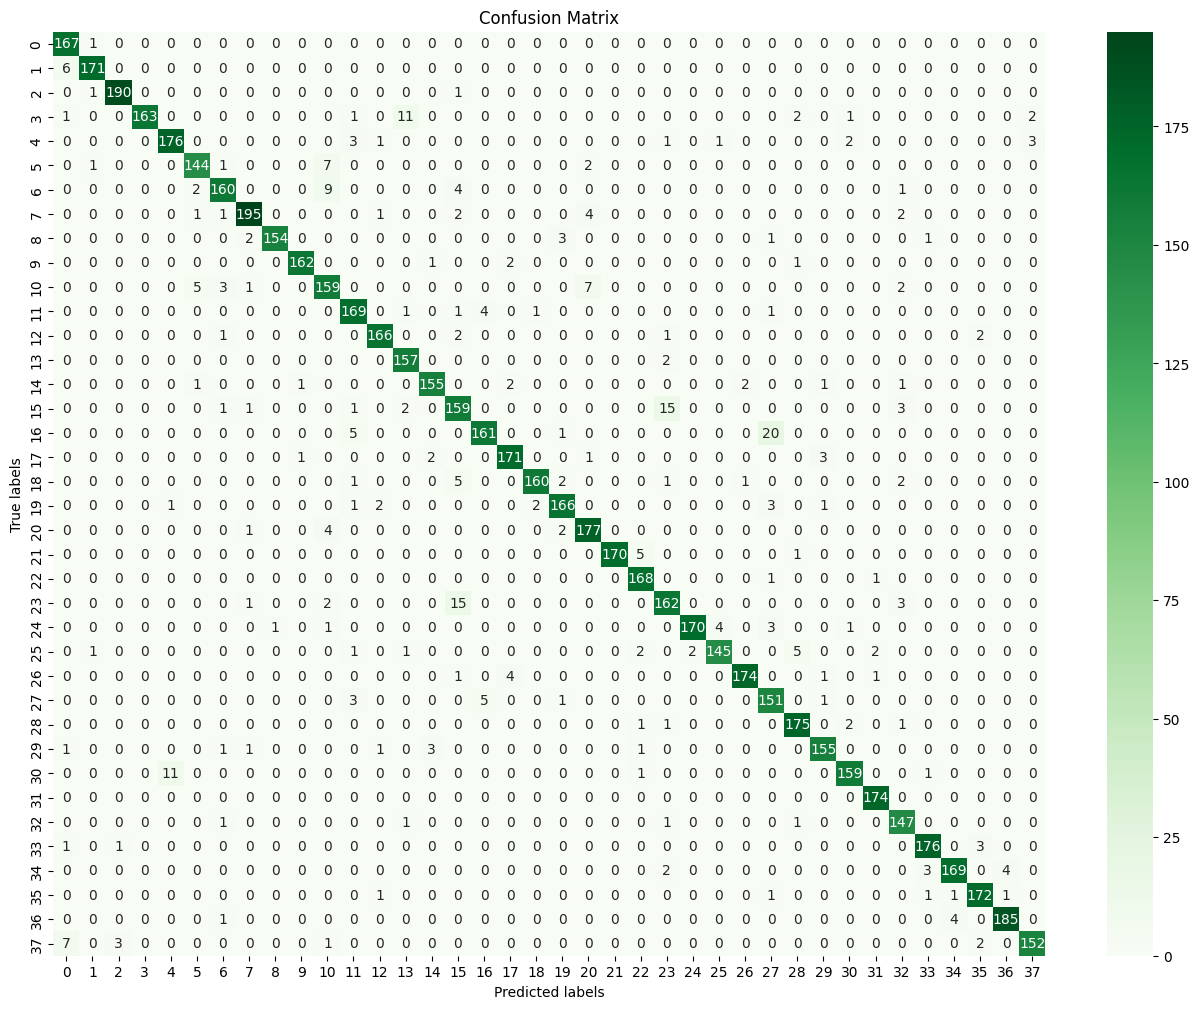

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##Result Analysis

1/1 [==============================] - 0s 27ms/step


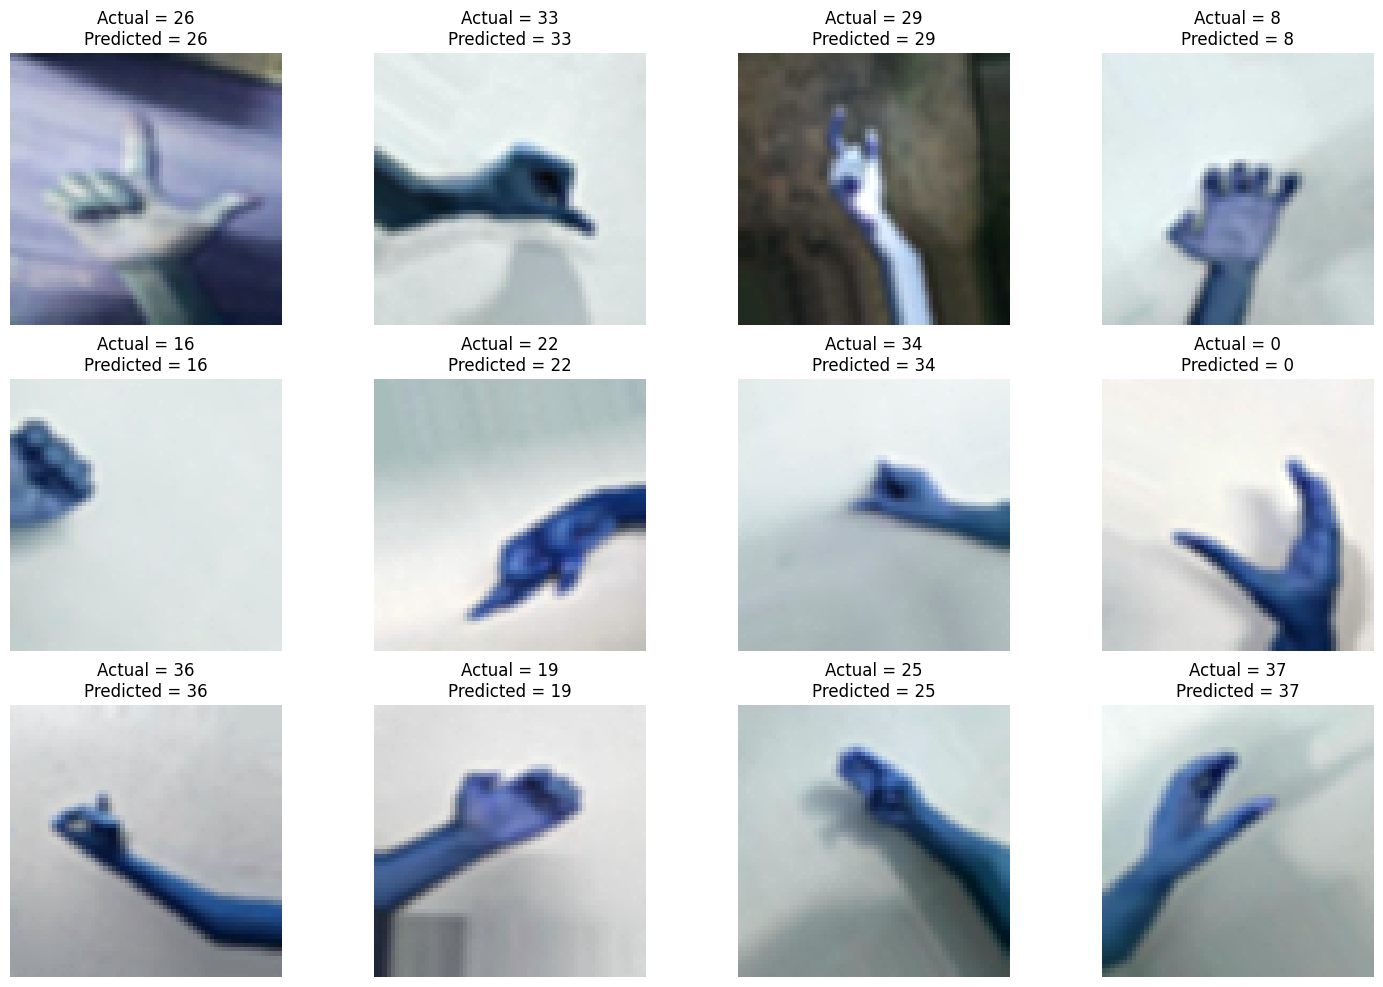

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_70epcs_92_acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
densenetmodel = load_model('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_70epcs_92_acc.h5')

y_pred = densenetmodel.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 5s 14ms/step
Accuracy: 0.9278288383305711
Precision: 0.9298129646897948
Recall: 0.9278042547868276
F1 Score: 0.927952006754876


# Test With Custom Data

In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

100% 3.82G/3.84G [00:39<00:00, 211MB/s]
100% 3.84G/3.84G [00:39<00:00, 105MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 81, 81)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:


main_folder_path = "/content/Custom DataSet/Data Set"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


37: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


In [ ]:

import pickle
with open('/content/data.pkl', 'wb') as file:
    pickle.dump(data, file)

with open('/content/labels.pkl', 'wb') as file:
    pickle.dump(labels, file)


In [ ]:
import pickle

# # Load x_train, x_test, y_train, and y_test
with open('/content/data.pkl', 'rb') as file:
    data = pickle.load(file)

with open('/content/labels (1).pkl', 'rb') as file:
    labels = pickle.load(file)



### MobileNet

In [ ]:
from keras.models import load_model

model = load_model("/content/mblent-20240328T162054Z-001/mblent/best_model_mobileNet_70epc_93acc.h5")


In [ ]:

predictions = model.predict(data)

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ['0','1','2','3','4','5','6','7','8','9','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']  # Update with your class labels

# Iterate through predictions and print results
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index] if class_labels else predicted_class_index
    print(f"Predicted class for image {i+1}: {predicted_class_label}")

119/119 [==============================] - 12s 93ms/step
Predicted class for image 1: 23
Predicted class for image 2: 23
Predicted class for image 3: 23
Predicted class for image 4: 6
Predicted class for image 5: 23
Predicted class for image 6: 23
Predicted class for image 7: 23
Predicted class for image 8: 10
Predicted class for image 9: 23
Predicted class for image 10: 32
Predicted class for image 11: 23
Predicted class for image 12: 32
Predicted class for image 13: 23
Predicted class for image 14: 23
Predicted class for image 15: 23
Predicted class for image 16: 23
Predicted class for image 17: 10
Predicted class for image 18: 23
Predicted class for image 19: 5
Predicted class for image 20: 23
Predicted class for image 21: 23
Predicted class for image 22: 5
Predicted class for image 23: 23
Predicted class for image 24: 23
Predicted class for image 25: 5
Predicted class for image 26: 23
Predicted class for image 27: 23
Predicted class for image 28: 23
Predicted class for image 29: 23

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
ground_truth_labels = labels
# Initialize LabelEncoder
label_encoder = LabelEncoder()
predicted_labels = np.argmax(predictions, axis=1)
# Fit LabelEncoder to your class labels and transform ground truth labels
encoded_ground_truth_labels = label_encoder.fit_transform(ground_truth_labels)

# Convert predicted labels back to string labels
predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_class_labels)

# Calculate precision
precision = precision_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate recall
recall = recall_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(ground_truth_labels, predicted_class_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8087345435411734
Precision: 0.844287932288983
Recall: 0.8087345435411734
F1 Score: 0.7853960558710849


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(ground_truth_labels, predicted_class_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96       100
          10       1.00      1.00      1.00       100
          11       0.96      0.78      0.86       100
          12       1.00      0.72      0.84       100
          13       0.97      1.00      0.99       100
          14       0.87      0.76      0.81       100
          15       0.87      0.55      0.67       100
          16       0.96      1.00      0.98       100
          17       0.83      1.00      0.91       100
          18       0.69      0.67      0.68       100
          19       0.93      1.00      0.96       100
           2       1.00      0.08      0.15       100
          20       0.71      1.00      0.83       100
          21       0.99      1.00      1.00       100
          22       1.00      0.06      0.11       100
          23       0.93      1.00      0.96       100
          24       0.87    

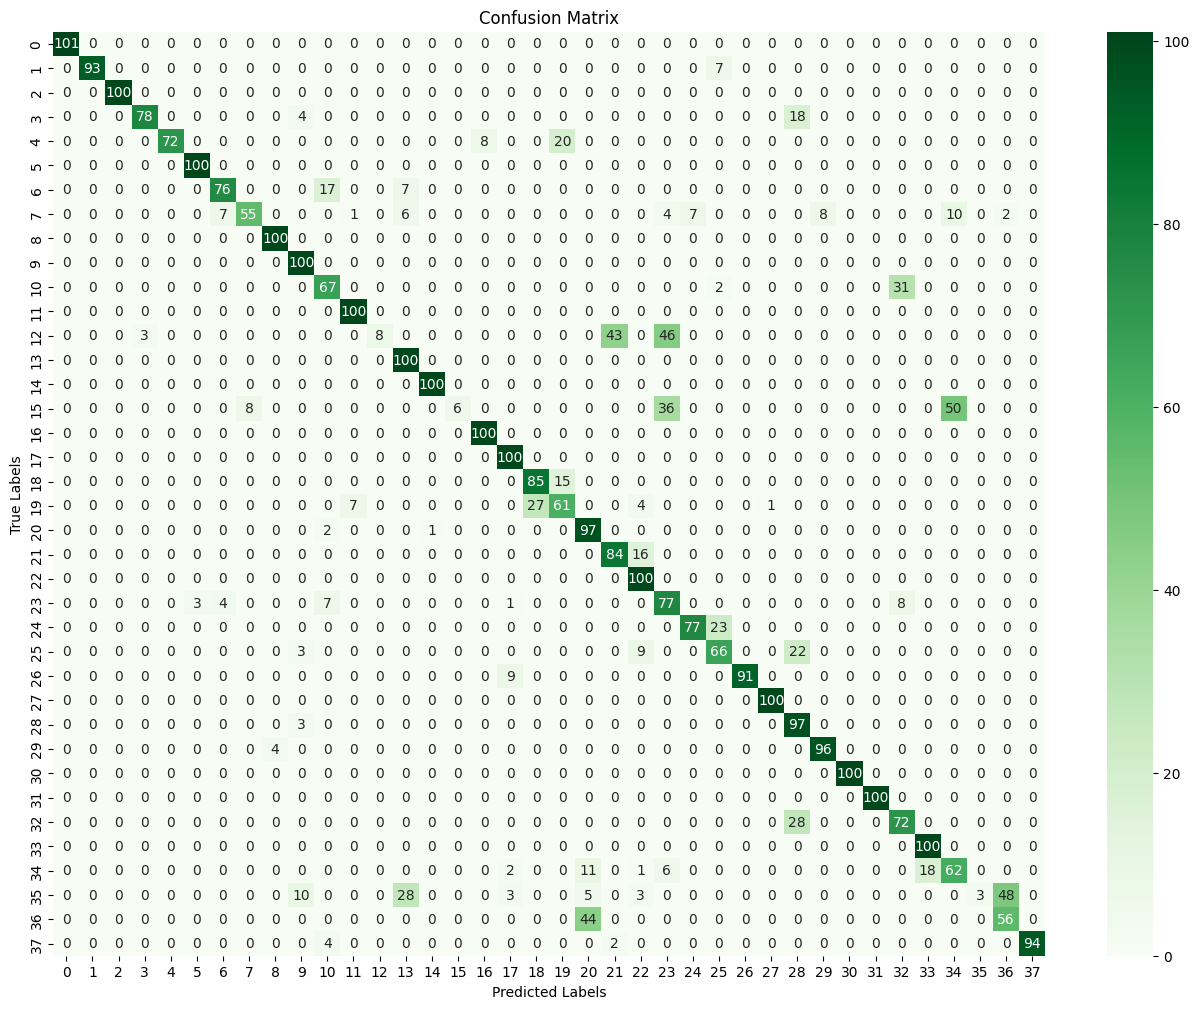

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_class_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### ResNEt50

In [ ]:
from keras.models import load_model

model = load_model("/content/BdSL_ResNEt50-20240328T162810Z-001/BdSL_ResNEt50/ResNet50_70epc_9150.h5")


In [ ]:

predictions = model.predict(data)

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ['0','1','2','3','4','5','6','7','8','9','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']  # Update with your class labels

# Iterate through predictions and print results
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index] if class_labels else predicted_class_index
    print(f"Predicted class for image {i+1}: {predicted_class_label}")

119/119 [==============================] - 86s 710ms/step
Predicted class for image 1: 23
Predicted class for image 2: 23
Predicted class for image 3: 23
Predicted class for image 4: 23
Predicted class for image 5: 23
Predicted class for image 6: 23
Predicted class for image 7: 23
Predicted class for image 8: 23
Predicted class for image 9: 23
Predicted class for image 10: 23
Predicted class for image 11: 23
Predicted class for image 12: 23
Predicted class for image 13: 23
Predicted class for image 14: 23
Predicted class for image 15: 23
Predicted class for image 16: 23
Predicted class for image 17: 23
Predicted class for image 18: 23
Predicted class for image 19: 23
Predicted class for image 20: 23
Predicted class for image 21: 23
Predicted class for image 22: 23
Predicted class for image 23: 23
Predicted class for image 24: 23
Predicted class for image 25: 23
Predicted class for image 26: 23
Predicted class for image 27: 23
Predicted class for image 28: 23
Predicted class for image 2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
ground_truth_labels = labels
# Initialize LabelEncoder
label_encoder = LabelEncoder()
predicted_labels = np.argmax(predictions, axis=1)
# Fit LabelEncoder to your class labels and transform ground truth labels
encoded_ground_truth_labels = label_encoder.fit_transform(ground_truth_labels)

# Convert predicted labels back to string labels
predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_class_labels)

# Calculate precision
precision = precision_score(ground_truth_labels, predicted_class_labels, average='weighted', zero_division=1)


# Calculate recall
recall = recall_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(ground_truth_labels, predicted_class_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8797684819784267
Precision: 0.8911810463781431
Recall: 0.8797684819784267
F1 Score: 0.864023937277845


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report with zero_division parameter set to 1
report = classification_report(ground_truth_labels, predicted_class_labels, zero_division=1)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       100
          10       0.88      1.00      0.94       100
          11       0.93      1.00      0.97       100
          12       1.00      0.80      0.89       100
          13       1.00      1.00      1.00       100
          14       0.99      0.94      0.96       100
          15       0.58      0.53      0.55       100
          16       0.98      1.00      0.99       100
          17       1.00      0.98      0.99       100
          18       0.74      0.59      0.66       100
          19       0.95      0.74      0.83       100
           2       0.92      0.97      0.95       100
          20       0.92      1.00      0.96       100
          21       0.92      1.00      0.96       100
          22       1.00      0.00      0.00       100
          23       0.82      0.94      0.87       100
          24       0.98    

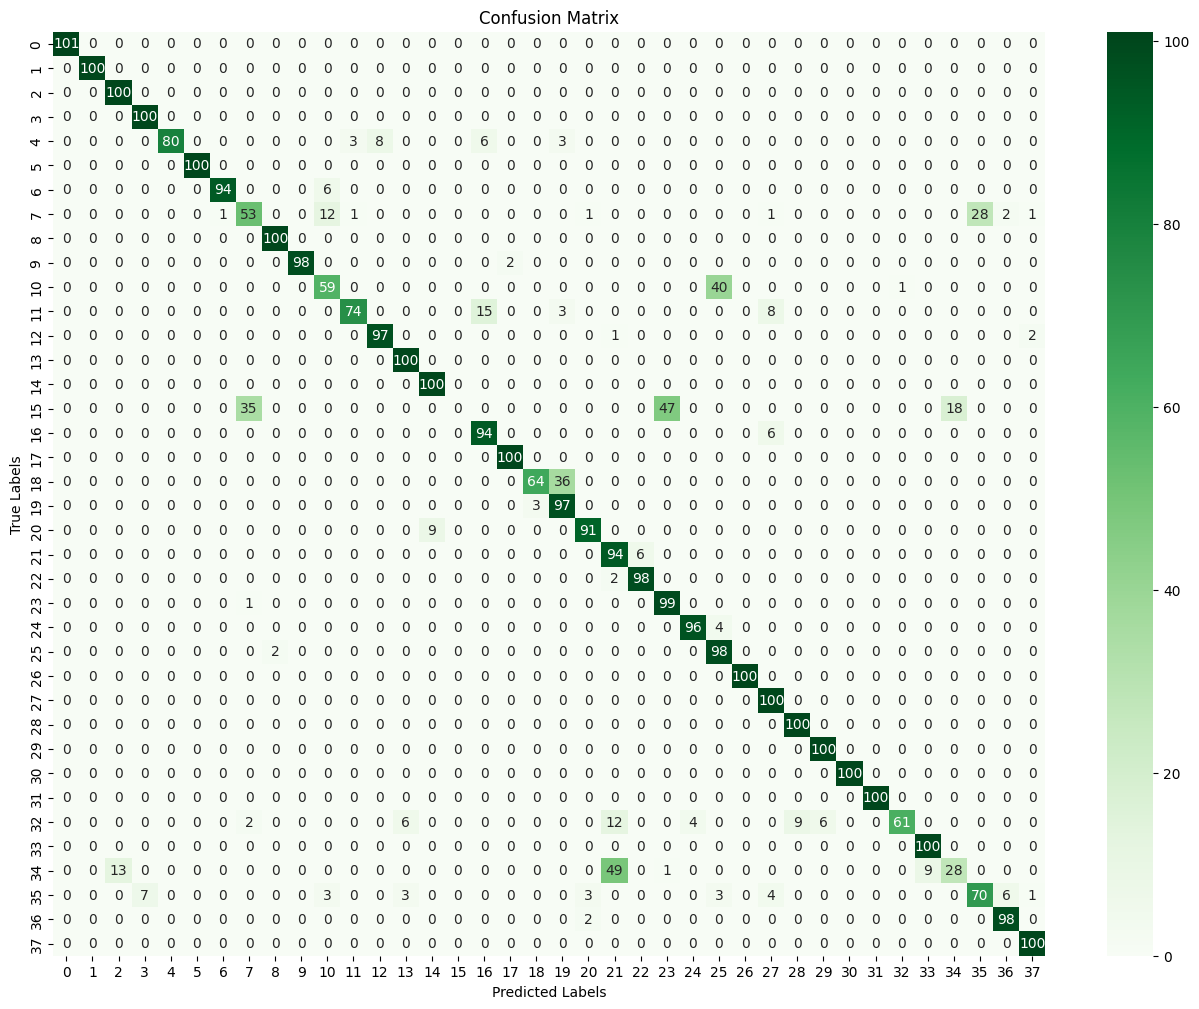

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_class_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### DenseNet121

In [ ]:
from keras.models import load_model

model = load_model("/content/DenseNet-20240330T185255Z-001/DenseNet/best_model_densenet_70epcs_92_acc.h5")


In [ ]:

predictions = model.predict(data)

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ['0','1','2','3','4','5','6','7','8','9','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']  # Update with your class labels

# Iterate through predictions and print results
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index] if class_labels else predicted_class_index
    print(f"Predicted class for image {i+1}: {predicted_class_label}")

119/119 [==============================] - 59s 453ms/step
Predicted class for image 1: 23
Predicted class for image 2: 23
Predicted class for image 3: 23
Predicted class for image 4: 23
Predicted class for image 5: 23
Predicted class for image 6: 23
Predicted class for image 7: 23
Predicted class for image 8: 23
Predicted class for image 9: 23
Predicted class for image 10: 23
Predicted class for image 11: 23
Predicted class for image 12: 23
Predicted class for image 13: 23
Predicted class for image 14: 23
Predicted class for image 15: 23
Predicted class for image 16: 23
Predicted class for image 17: 23
Predicted class for image 18: 23
Predicted class for image 19: 23
Predicted class for image 20: 23
Predicted class for image 21: 23
Predicted class for image 22: 23
Predicted class for image 23: 23
Predicted class for image 24: 23
Predicted class for image 25: 23
Predicted class for image 26: 23
Predicted class for image 27: 23
Predicted class for image 28: 23
Predicted class for image 2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
ground_truth_labels = labels
# Initialize LabelEncoder
label_encoder = LabelEncoder()
predicted_labels = np.argmax(predictions, axis=1)
# Fit LabelEncoder to your class labels and transform ground truth labels
encoded_ground_truth_labels = label_encoder.fit_transform(ground_truth_labels)

# Convert predicted labels back to string labels
predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_class_labels)

# Calculate precision
precision = precision_score(ground_truth_labels, predicted_class_labels, average='weighted', zero_division=1)


# Calculate recall
recall = recall_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(ground_truth_labels, predicted_class_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8242567745330176
Precision: 0.8868020708744226
Recall: 0.8242567745330176
F1 Score: 0.8048613859275736


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report with zero_division parameter set to 1
report = classification_report(ground_truth_labels, predicted_class_labels, zero_division=1)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.96      0.77      0.86       101
           1       1.00      1.00      1.00       100
          10       1.00      0.93      0.96       100
          11       0.47      0.99      0.64       100
          12       1.00      0.79      0.88       100
          13       1.00      0.08      0.15       100
          14       1.00      0.57      0.73       100
          15       0.73      0.84      0.78       100
          16       1.00      1.00      1.00       100
          17       1.00      0.99      0.99       100
          18       0.89      0.98      0.93       100
          19       0.90      0.92      0.91       100
           2       0.94      0.83      0.88       100
          20       1.00      0.00      0.00       100
          21       1.00      1.00      1.00       100
          22       1.00      0.00      0.00       100
          23       0.90      0.75      0.82       100
          24       0.99    

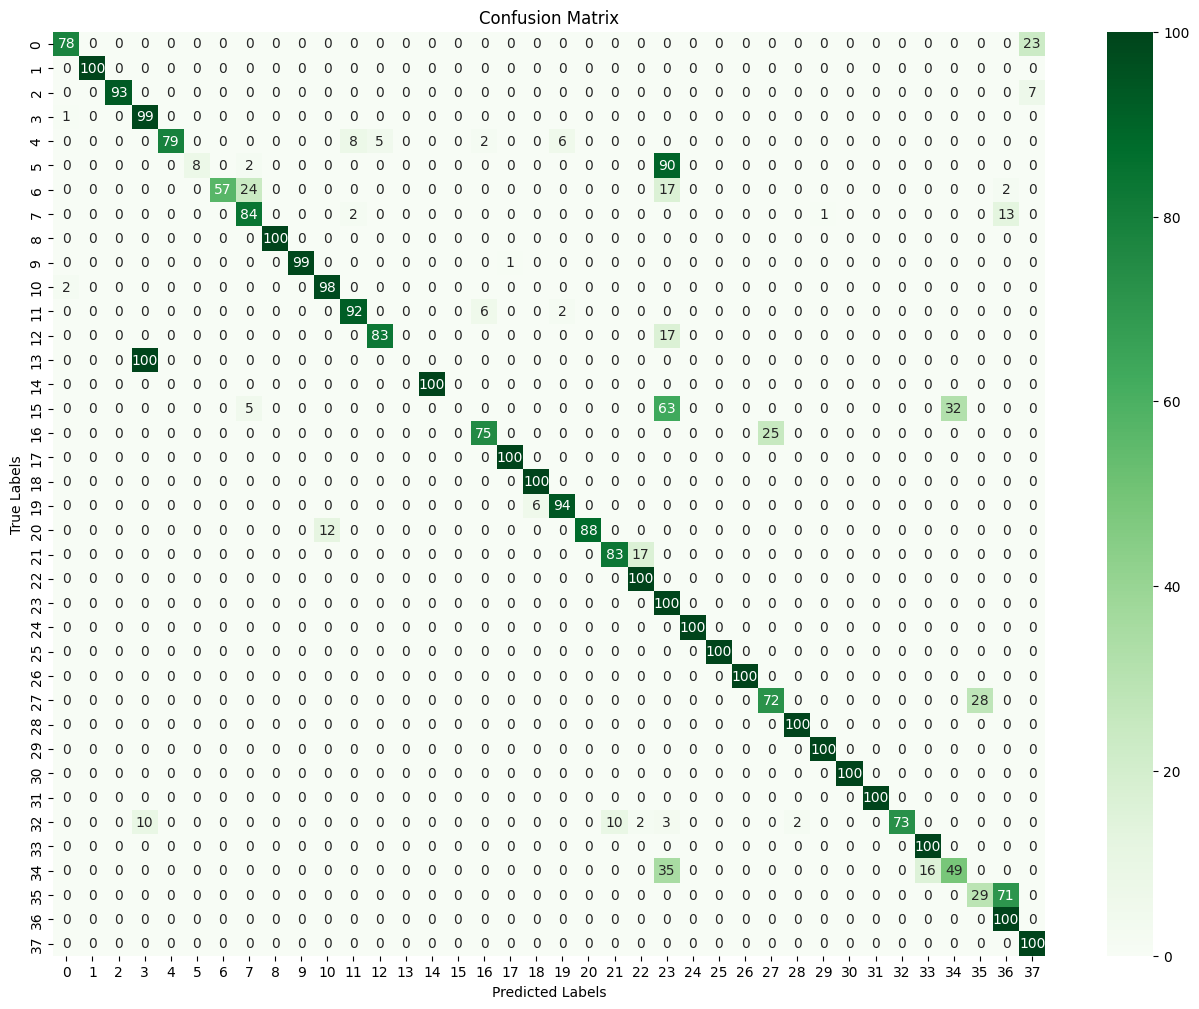

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_class_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Efficient Net B1

In [ ]:
from keras.models import load_model

model = load_model("/content/Efficient-20240329T081737Z-001/Efficient/best_model_efficient_50epcs_95_acc.h5")


In [ ]:

predictions = model.predict(data)

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ['0','1','2','3','4','5','6','7','8','9','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']  # Update with your class labels

# Iterate through predictions and print results
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index] if class_labels else predicted_class_index
    print(f"Predicted class for image {i+1}: {predicted_class_label}")

119/119 [==============================] - 50s 380ms/step
Predicted class for image 1: 6
Predicted class for image 2: 23
Predicted class for image 3: 23
Predicted class for image 4: 23
Predicted class for image 5: 23
Predicted class for image 6: 23
Predicted class for image 7: 23
Predicted class for image 8: 23
Predicted class for image 9: 23
Predicted class for image 10: 32
Predicted class for image 11: 23
Predicted class for image 12: 23
Predicted class for image 13: 23
Predicted class for image 14: 23
Predicted class for image 15: 23
Predicted class for image 16: 23
Predicted class for image 17: 23
Predicted class for image 18: 23
Predicted class for image 19: 6
Predicted class for image 20: 23
Predicted class for image 21: 23
Predicted class for image 22: 6
Predicted class for image 23: 23
Predicted class for image 24: 23
Predicted class for image 25: 23
Predicted class for image 26: 23
Predicted class for image 27: 23
Predicted class for image 28: 23
Predicted class for image 29: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
ground_truth_labels = labels
# Initialize LabelEncoder
label_encoder = LabelEncoder()
predicted_labels = np.argmax(predictions, axis=1)
# Fit LabelEncoder to your class labels and transform ground truth labels
encoded_ground_truth_labels = label_encoder.fit_transform(ground_truth_labels)

# Convert predicted labels back to string labels
predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_class_labels)

# Calculate precision
precision = precision_score(ground_truth_labels, predicted_class_labels, average='weighted', zero_division=1)


# Calculate recall
recall = recall_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(ground_truth_labels, predicted_class_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8337279663246514
Precision: 0.8456739669931534
Recall: 0.8337279663246514
F1 Score: 0.8143051990206993


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report with zero_division parameter set to 1
report = classification_report(ground_truth_labels, predicted_class_labels, zero_division=1)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       0.83      1.00      0.90       100
          12       1.00      0.79      0.88       100
          13       1.00      1.00      1.00       100
          14       0.92      0.98      0.95       100
          15       0.36      0.24      0.29       100
          16       1.00      1.00      1.00       100
          17       0.94      1.00      0.97       100
          18       0.36      0.22      0.27       100
          19       0.95      1.00      0.98       100
           2       1.00      0.48      0.65       100
          20       0.75      1.00      0.86       100
          21       1.00      1.00      1.00       100
          22       1.00      0.06      0.11       100
          23       0.91      0.72      0.80       100
          24       1.00    

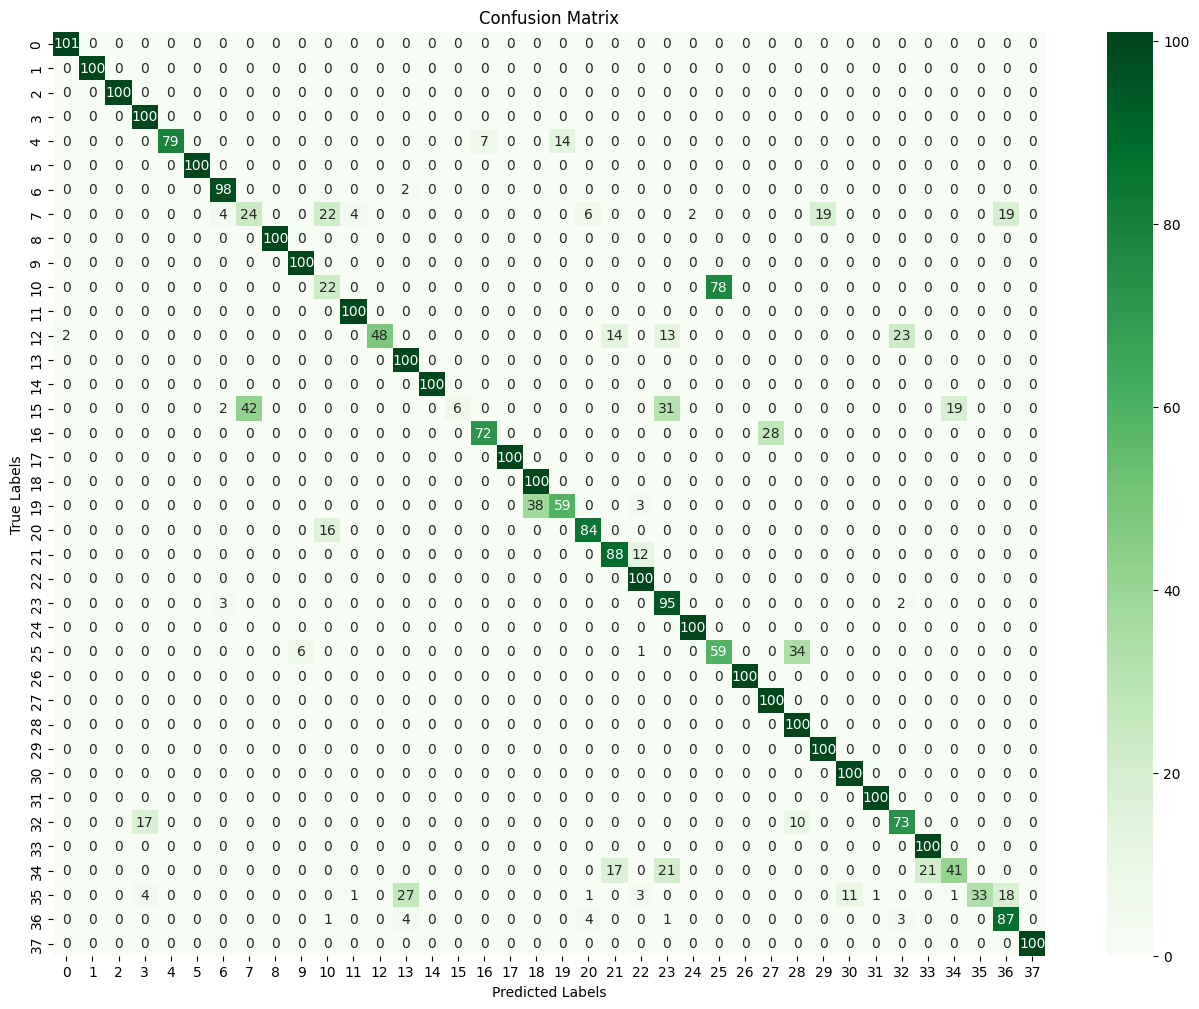

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_class_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### YOLO

In [ ]:
from keras.models import load_model

model = load_model("/content/Yolov5_client-20240328T183756Z-001/Yolov5_client/best_model_yolov5_94_acc.h5")


In [ ]:

predictions = model.predict(data)

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ['0','1','2','3','4','5','6','7','8','9','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']  # Update with your class labels

# Iterate through predictions and print results
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index] if class_labels else predicted_class_index
    print(f"Predicted class for image {i+1}: {predicted_class_label}")

119/119 [==============================] - 64s 526ms/step
Predicted class for image 1: 23
Predicted class for image 2: 23
Predicted class for image 3: 23
Predicted class for image 4: 23
Predicted class for image 5: 23
Predicted class for image 6: 23
Predicted class for image 7: 23
Predicted class for image 8: 23
Predicted class for image 9: 23
Predicted class for image 10: 23
Predicted class for image 11: 23
Predicted class for image 12: 23
Predicted class for image 13: 23
Predicted class for image 14: 23
Predicted class for image 15: 23
Predicted class for image 16: 23
Predicted class for image 17: 23
Predicted class for image 18: 23
Predicted class for image 19: 23
Predicted class for image 20: 23
Predicted class for image 21: 23
Predicted class for image 22: 23
Predicted class for image 23: 23
Predicted class for image 24: 23
Predicted class for image 25: 23
Predicted class for image 26: 23
Predicted class for image 27: 23
Predicted class for image 28: 23
Predicted class for image 2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
ground_truth_labels = labels
# Initialize LabelEncoder
label_encoder = LabelEncoder()
predicted_labels = np.argmax(predictions, axis=1)
# Fit LabelEncoder to your class labels and transform ground truth labels
encoded_ground_truth_labels = label_encoder.fit_transform(ground_truth_labels)

# Convert predicted labels back to string labels
predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_class_labels)

# Calculate precision
precision = precision_score(ground_truth_labels, predicted_class_labels, average='weighted', zero_division=1)


# Calculate recall
recall = recall_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(ground_truth_labels, predicted_class_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8813470139436991
Precision: 0.9023513067555131
Recall: 0.8813470139436991
F1 Score: 0.8695731272160492


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report with zero_division parameter set to 1
report = classification_report(ground_truth_labels, predicted_class_labels, zero_division=1)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.81      1.00      0.90       101
           1       1.00      0.77      0.87       100
          10       0.88      1.00      0.94       100
          11       0.80      0.99      0.88       100
          12       1.00      0.78      0.88       100
          13       1.00      1.00      1.00       100
          14       1.00      0.33      0.50       100
          15       0.78      0.88      0.83       100
          16       1.00      1.00      1.00       100
          17       0.99      1.00      1.00       100
          18       0.91      0.62      0.74       100
          19       0.88      1.00      0.94       100
           2       1.00      0.95      0.97       100
          20       0.72      1.00      0.84       100
          21       1.00      1.00      1.00       100
          22       1.00      0.09      0.17       100
          23       0.94      1.00      0.97       100
          24       1.00    

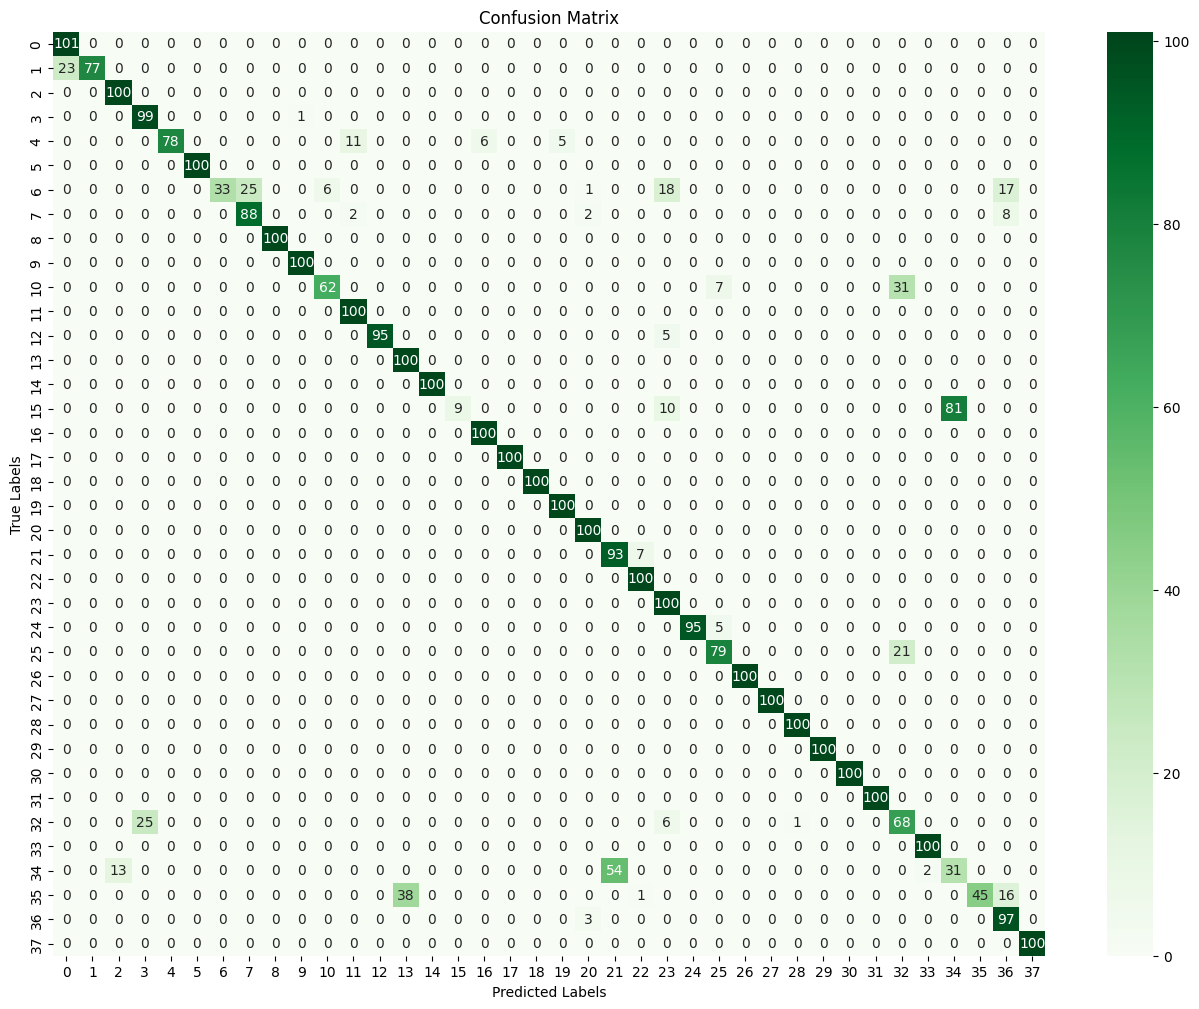

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_class_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### InceptionV3

In [ ]:
from keras.models import load_model

model = load_model("/content/best_model_inception_60epc_85acc.h5")


In [ ]:

predictions = model.predict(data)

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ['0','1','2','3','4','5','6','7','8','9','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']  # Update with your class labels

# Iterate through predictions and print results
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index] if class_labels else predicted_class_index
    print(f"Predicted class for image {i+1}: {predicted_class_label}")

119/119 [==============================] - 37s 299ms/step
Predicted class for image 1: 23
Predicted class for image 2: 23
Predicted class for image 3: 23
Predicted class for image 4: 10
Predicted class for image 5: 23
Predicted class for image 6: 23
Predicted class for image 7: 23
Predicted class for image 8: 10
Predicted class for image 9: 23
Predicted class for image 10: 23
Predicted class for image 11: 23
Predicted class for image 12: 23
Predicted class for image 13: 23
Predicted class for image 14: 10
Predicted class for image 15: 23
Predicted class for image 16: 23
Predicted class for image 17: 23
Predicted class for image 18: 23
Predicted class for image 19: 23
Predicted class for image 20: 23
Predicted class for image 21: 23
Predicted class for image 22: 23
Predicted class for image 23: 10
Predicted class for image 24: 23
Predicted class for image 25: 23
Predicted class for image 26: 23
Predicted class for image 27: 23
Predicted class for image 28: 23
Predicted class for image 2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
ground_truth_labels = labels
# Initialize LabelEncoder
label_encoder = LabelEncoder()
predicted_labels = np.argmax(predictions, axis=1)
# Fit LabelEncoder to your class labels and transform ground truth labels
encoded_ground_truth_labels = label_encoder.fit_transform(ground_truth_labels)

# Convert predicted labels back to string labels
predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_class_labels)

# Calculate precision
precision = precision_score(ground_truth_labels, predicted_class_labels, average='weighted', zero_division=1)


# Calculate recall
recall = recall_score(ground_truth_labels, predicted_class_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(ground_truth_labels, predicted_class_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7258616153643778
Precision: 0.7993007799323919
Recall: 0.7258616153643778
F1 Score: 0.6907965083274773


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report with zero_division parameter set to 1
report = classification_report(ground_truth_labels, predicted_class_labels, zero_division=1)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       101
           1       1.00      0.98      0.99       100
          10       1.00      1.00      1.00       100
          11       1.00      0.37      0.54       100
          12       1.00      0.72      0.84       100
          13       0.92      1.00      0.96       100
          14       1.00      0.59      0.74       100
          15       0.97      0.29      0.45       100
          16       0.92      1.00      0.96       100
          17       0.81      0.63      0.71       100
          18       0.48      0.56      0.52       100
          19       0.46      0.98      0.63       100
           2       1.00      0.00      0.00       100
          20       0.62      0.52      0.57       100
          21       0.96      1.00      0.98       100
          22       1.00      0.00      0.00       100
          23       0.91      0.96      0.94       100
          24       0.81    

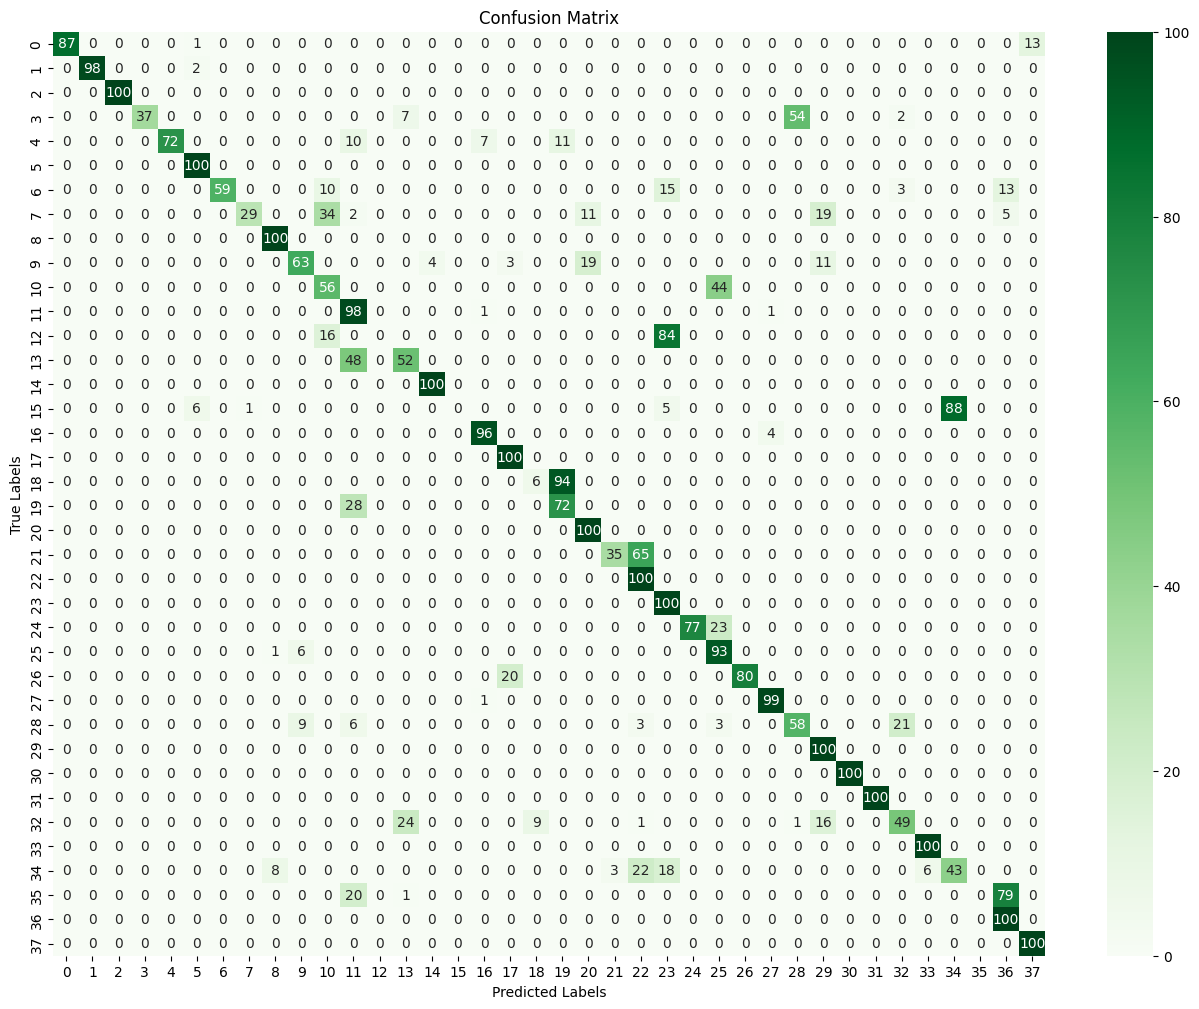

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_class_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Prediction

In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

100% 4.06G/4.07G [01:00<00:00, 41.1MB/s]
100% 4.07G/4.07G [01:00<00:00, 72.7MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
model = keras.models.load_model('/content/Efficient-20240329T081737Z-001/Efficient/best_model_efficient_50epcs_95_acc.h5')


In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def processed_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def prediction(input_image_path):
    predicted_Output = ['অ/য়','আ/ া','খ/ক্ষ','গ','ঘ','ঙ','চ','ছ ','জ/ য','ঝ ','ঞ','ট',
                        'ই/ঈ','ঠ','ড','ঢ ','ত/ৎ','থ','দ','ধ','ণ/ ন','প','ফ',
                        'উ/ঊ','ব/ভ','ম','ল',' শ/ষ/ স','হ',' ঁ',' ং','ঃ',
                        'ঋ, র, ড়, ঢ়','এ/ে','ঐ/ ৈ','ও/ ো','ঔ/ৌ','ক']

    # input_image_path = input("Give the image path: ")
    # img = cv2.imread(input_image_path)
    img = processed_image(input_image_path)
    # img = cv2.resize(img, (150, 150))
    img_array = np.array(img)
    img_array = img_array.reshape(1, 64, 64, 3)

    plt.figure(figsize=(4, 3))
    img = image.load_img(input_image_path)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

    threshold = 0.7

    a = model.predict(img_array)
    highest_probability = max(a[0])
    indices = a.argmax()  # Initialize indices here
    if highest_probability < threshold:
        print("Image doesn't match any known class.")
    else:
        print("Probability ->")
        for i, probability in enumerate(a[0]):
            print(f"{predicted_Output[i]}: {probability:.4f}")
        print(f"\nPredicted Class: {predicted_Output[indices]}")



##Predict Single Image

Give the image path: /content/AUGMENTED_DATASET-20240326T154347Z-001/AUGMENTED_DATASET/28/20180625_200230_0_3283.jpg


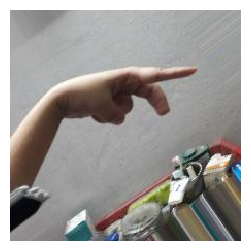

1/1 [==============================] - 0s 119ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 1.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: প


In [ ]:
prediction(input("Give the image path: "))

##Predict Single Image for each class

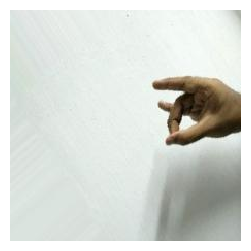

1/1 [==============================] - 0s 64ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0001
চ: 0.0027
ছ : 0.9788
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0004
ট: 0.0000
 ই/ঈ : 0.0009
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0045
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0001
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0104
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0006
ও/ ো: 0.0000
ঔ/ৌ: 0.0013
ক: 0.0000

Predicted Class: ছ 


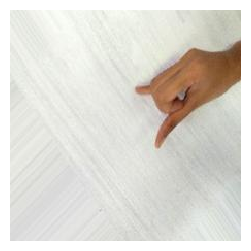

1/1 [==============================] - 0s 73ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0001
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0002
ঐ/ ৈ: 0.9997
ও/ ো: 0.0000
ঔ/ৌ: 0.0001
ক: 0.0000

Predicted Class: ঐ/ ৈ


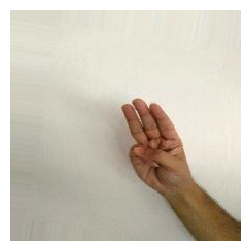

1/1 [==============================] - 0s 50ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 1.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ম


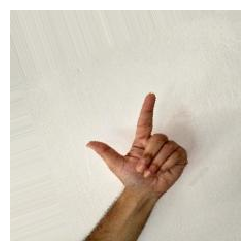

1/1 [==============================] - 0s 53ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0002
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0004
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0004
দ: 0.0000
ধ: 0.0001
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.9047
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0941
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ল


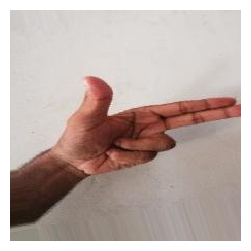

1/1 [==============================] - 0s 53ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 1.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঝ 


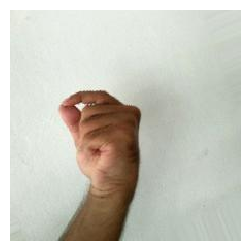

1/1 [==============================] - 0s 54ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.9957
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0035
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0005
ঃ: 0.0001
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঘ


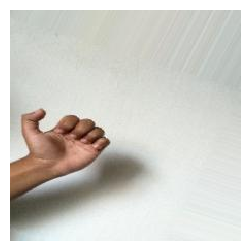

1/1 [==============================] - 0s 54ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0014
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0001
থ: 0.0000
দ: 0.0007
ধ: 0.9977
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ধ


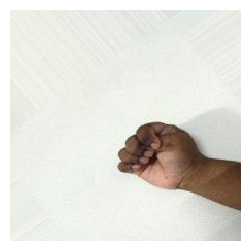

1/1 [==============================] - 0s 62ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0003
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0006
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.2702
থ: 0.0000
দ: 0.0000
ধ: 0.0007
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0001
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.7274
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0001
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0005
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class:  শ/ষ/ স


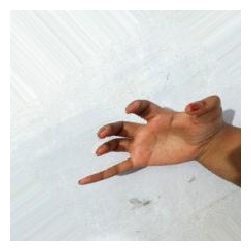

1/1 [==============================] - 0s 53ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 1.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: জ/ য


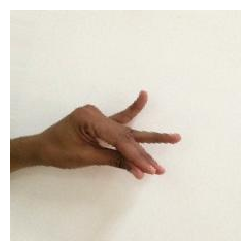

1/1 [==============================] - 0s 51ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 1.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ণ/ ন


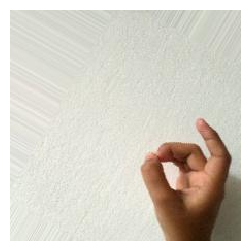

1/1 [==============================] - 0s 42ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0002
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.9982
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0016
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class:  ই/ঈ 


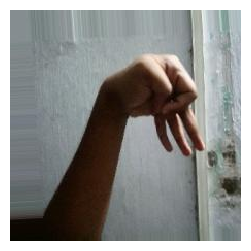

1/1 [==============================] - 0s 65ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0024
ফ: 0.9975
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ফ


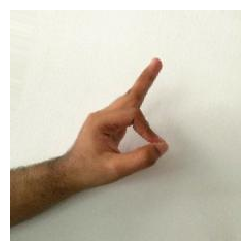

1/1 [==============================] - 0s 50ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.9985
ছ : 0.0011
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0003
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: চ


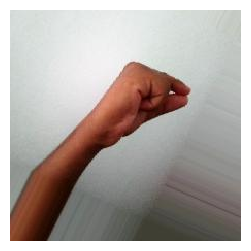

1/1 [==============================] - 0s 56ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 1.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class:  ং


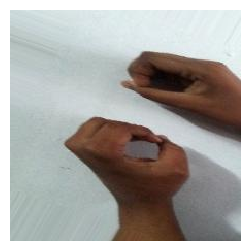

1/1 [==============================] - 0s 100ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 1.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঃ


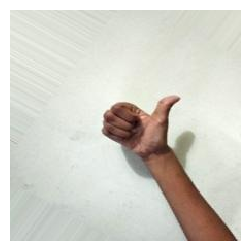

1/1 [==============================] - 0s 111ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 1.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: দ


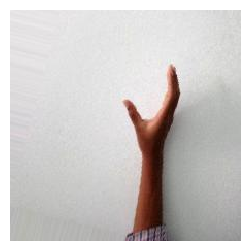

1/1 [==============================] - 0s 71ms/step
Probability ->
অ/য়: 0.9932
আ/ া: 0.0065
খ/ক্ষ: 0.0001
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0003
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: অ/য়


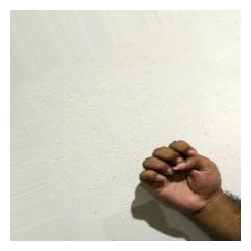

1/1 [==============================] - 0s 119ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0001
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0032
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.9966
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class:  শ/ষ/ স


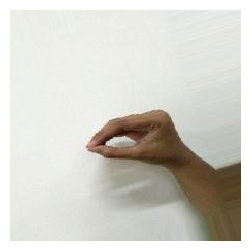

1/1 [==============================] - 0s 48ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.9999
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ও/ ো


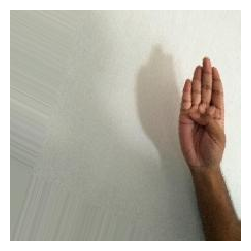

1/1 [==============================] - 0s 110ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.9994
ম: 0.0006
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ব/ভ


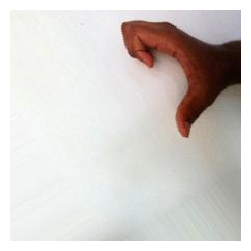

1/1 [==============================] - 0s 86ms/step
Probability ->
অ/য়: 0.8636
আ/ া: 0.0641
খ/ক্ষ: 0.0638
গ: 0.0001
ঘ: 0.0000
ঙ: 0.0012
চ: 0.0001
ছ : 0.0001
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0001
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0001
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0019
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0004
এ/ে: 0.0005
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0040

Predicted Class: অ/য়


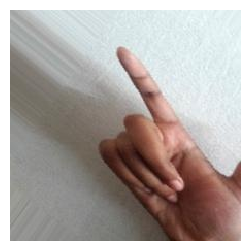

1/1 [==============================] - 0s 42ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0002
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0001
জ/ য: 0.0000
ঝ : 0.0003
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0026
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.9393
দ: 0.0001
ধ: 0.0000
ণ/ ন: 0.0004
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0005
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0002
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0561
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0001
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: থ


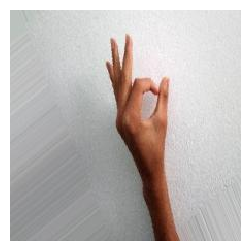

1/1 [==============================] - 0s 49ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.9732
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0255
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0012
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঙ


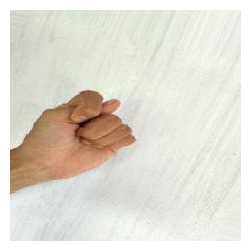

1/1 [==============================] - 0s 41ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.9995
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0004
থ: 0.0000
দ: 0.0000
ধ: 0.0001
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ট


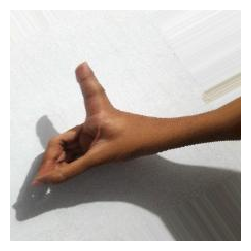

1/1 [==============================] - 0s 45ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0009
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.9991
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঢ 


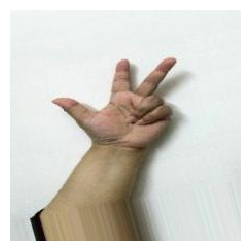

1/1 [==============================] - 0s 42ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 1.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ড 


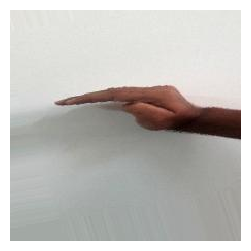

1/1 [==============================] - 0s 61ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 1.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: গ


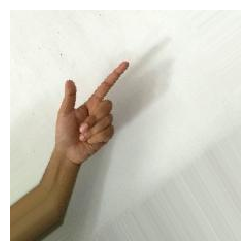

1/1 [==============================] - 0s 41ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0002
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.9930
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0067
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: থ


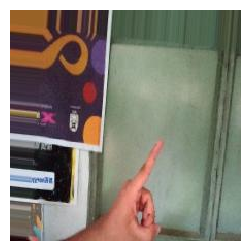

1/1 [==============================] - 0s 47ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0003
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.9993
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0003
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class:  উ/ঊ


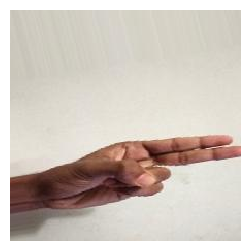

1/1 [==============================] - 0s 42ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 1.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: হ


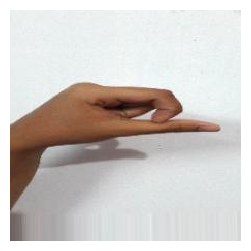

1/1 [==============================] - 0s 43ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0004
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.9996
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: এ/ে


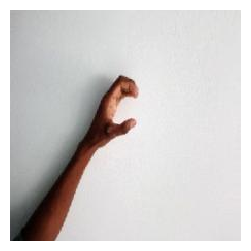

1/1 [==============================] - 0s 43ms/step
Probability ->
অ/য়: 0.0088
আ/ া: 0.0000
খ/ক্ষ: 0.0003
গ: 0.0001
ঘ: 0.0001
ঙ: 0.0004
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0029
ঝ : 0.0000
ঞ: 0.0005
ট: 0.0000
 ই/ঈ : 0.0009
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0001
ফ: 0.0000
 উ/ঊ: 0.0001
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0002
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0017
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0007
ঐ/ ৈ: 0.0000
ও/ ো: 0.0001
ঔ/ৌ: 0.0000
ক: 0.9832

Predicted Class: ক


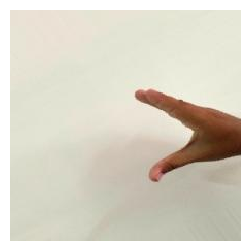

1/1 [==============================] - 0s 42ms/step
Probability ->
অ/য়: 0.0302
আ/ া: 0.9690
খ/ক্ষ: 0.0004
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0001
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0001
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0001
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: আ/ া


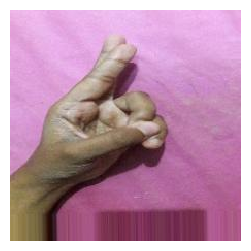

1/1 [==============================] - 0s 57ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0001
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0023
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0029
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.9946
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঋ, র, ড়, ঢ়


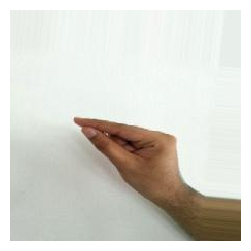

1/1 [==============================] - 0s 47ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 1.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঠ


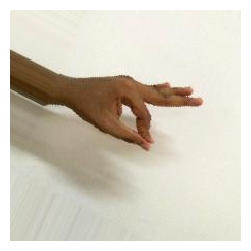

1/1 [==============================] - 0s 44ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0001
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.9998
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: ঞ


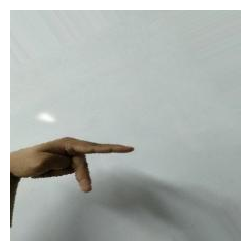

1/1 [==============================] - 0s 47ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 1.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 0.0000
ক: 0.0000

Predicted Class: প


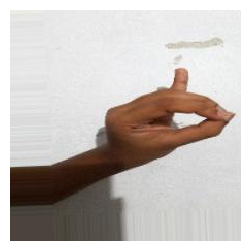

1/1 [==============================] - 0s 48ms/step
Probability ->
অ/য়: 0.0000
আ/ া: 0.0000
খ/ক্ষ: 0.0000
গ: 0.0000
ঘ: 0.0000
ঙ: 0.0000
চ: 0.0000
ছ : 0.0000
জ/ য: 0.0000
ঝ : 0.0000
ঞ: 0.0000
ট: 0.0000
 ই/ঈ : 0.0000
ঠ: 0.0000
ড : 0.0000
ঢ : 0.0000
ত/ৎ: 0.0000
থ: 0.0000
দ: 0.0000
ধ: 0.0000
ণ/ ন: 0.0000
প: 0.0000
ফ: 0.0000
 উ/ঊ: 0.0000
ব/ভ: 0.0000
ম: 0.0000
ল: 0.0000
 শ/ষ/ স: 0.0000
হ: 0.0000
 ঁ: 0.0000
 ং: 0.0000
ঃ: 0.0000
ঋ, র, ড়, ঢ়: 0.0000
এ/ে: 0.0000
ঐ/ ৈ: 0.0000
ও/ ো: 0.0000
ঔ/ৌ: 1.0000
ক: 0.0000

Predicted Class: ঔ/ৌ


In [ ]:
import os
import random

# Path to the main directory containing all folders
main_directory = "/content/AUGMENTED_DATASET-20240326T154347Z-001/AUGMENTED_DATASET"

# Loop through each folder in the main directory
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    if os.path.isdir(folder_path):
        files_in_folder = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        if files_in_folder:
            random_file = random.choice(files_in_folder)
            image_path = os.path.join(folder_path, random_file)
            prediction(image_path)


##Example of Wrong Prediction

Give the image path: /content/412752629_417064590649543_441281696984423413_n.jpg


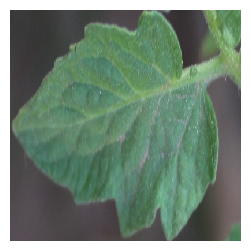

1/1 [==============================] - 0s 50ms/step
Image doesn't match any known class.
Give the image path: /content/414130794_1212474116376164_7112059191792248760_n.jpg


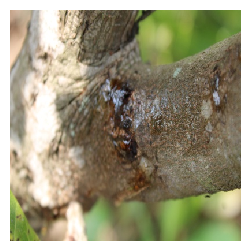

1/1 [==============================] - 0s 65ms/step
Image doesn't match any known class.
Give the image path: /content/415294366_394588429652540_4790417039880672904_n.jpg


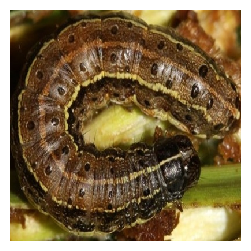

1/1 [==============================] - 0s 52ms/step
Image doesn't match any known class.


In [ ]:
for i in range (3):
  prediction(input("Give the image path: "))
  i = i+1

Give the image path: /content/download.jpeg


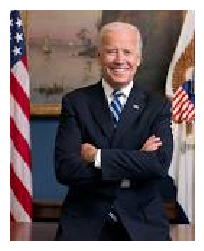

1/1 [==============================] - 0s 54ms/step
Image doesn't match any known class.


In [ ]:
prediction(input("Give the image path: "))

Give the image path: /content/435683214_3364280807195199_8679112250918186856_n.jpg


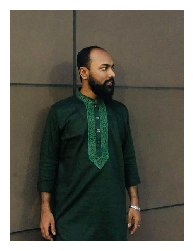

1/1 [==============================] - 9s 9s/step
Image doesn't match any known class.


In [ ]:
prediction(input("Give the image path: "))

# Confusion Matrix With bangla font

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2527 (\N{BENGALI LETTER YYA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2454 (\N{BENGALI LETTER KHA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: User

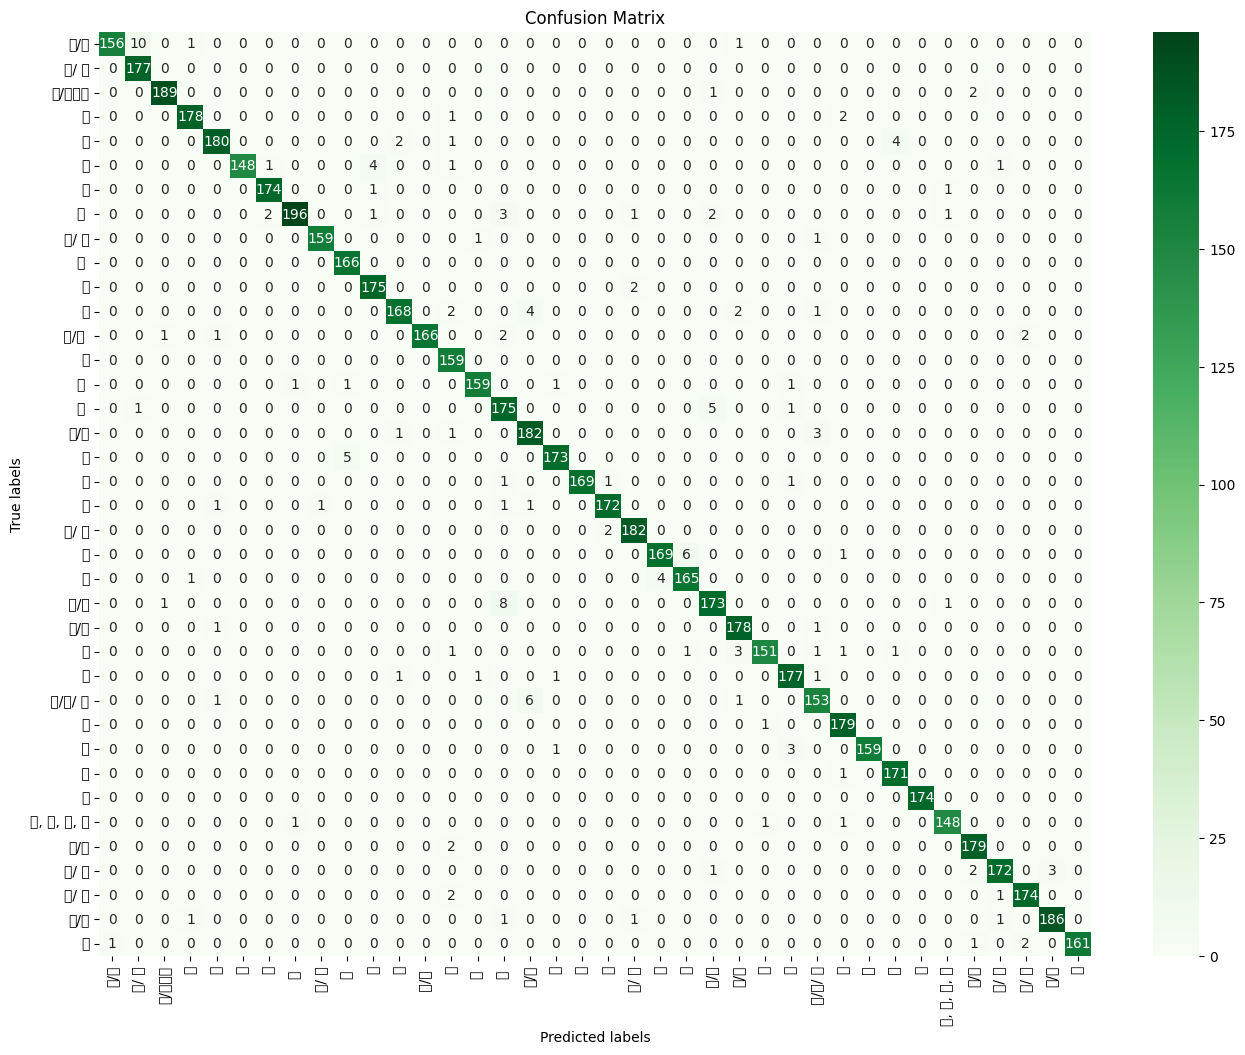

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',xticklabels=predicted_Output, yticklabels=predicted_Output)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()